In [91]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from pyspark.sql import functions as F  # Importing necessary functions
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [92]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/china_082019_2_tweets_csv_hashed.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)
from pyspark.sql.functions import col, array

df = df.drop("user_profile_description", "account_language", "tweet_text", "tweet_time", "tweet_client_name", "in_reply_to_userid", "in_reply_to_tweetid", "quoted_tweet_tweetid", "retweet_userid", "retweet_tweetid", "latitude", "longitude", "user_mentions", "poll_choices", "hashtags", "urls", "user_screen_name")

df = df.withColumn("follower_count", col("follower_count").cast(IntegerType()))
df = df.withColumn("following_count", col("following_count").cast(IntegerType()))
df = df.withColumn("quote_count", col("quote_count").cast(IntegerType()))
df = df.withColumn("reply_count", col("reply_count").cast(IntegerType()))
df = df.withColumn("like_count", col("like_count").cast(IntegerType()))
df = df.withColumn("retweet_count", col("retweet_count").cast(IntegerType()))
df = df.withColumn("is_retweet", col("is_retweet").cast("boolean"))

print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


In [93]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
total_twitter_count = df.count()
print('Rows count:')
total_twitter_count

Data overview
root
 |-- tweetid: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- user_display_name: string (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- user_profile_url: string (nullable = true)
 |-- follower_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- account_creation_date: string (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)

Columns overview


Column Name Data type
0                  tweetid    string
1                   userid    string
2        user_display_name    string
3   user_reported_location    string
4         user_profile_url    string
5           follower_count       int
6          following_count       int
7    account_creation_date    string
8           tweet_language    string
9               is_retweet   boolean
10             quote_count       int
11             reply_count       int
12              like_count       int
13           retweet_count       int

Rows count:


3409749

In [94]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 12 data rows:')
df.limit(12).toPandas()

Data frame describe (string and numeric columns only):


summary                                            tweetid  \
0   count                                            3408798   
1    mean                              4.5722168332515322E17   
2  stddev                               3.917130024526647E17   
3     min  \t\t\t\t\tA Hideaway for Wine http://nyti.ms/i...   
4     max                       󾕈 هل يفسد الصوم ببلع الريق 󾕈   

                  userid user_display_name  user_reported_location  \
0                2202907           2212778                 1212769   
1  2.6596407282490356E14          Infinity   4.7670992038154771E17   
2   1.564292916087894E16               NaN  2.46680883301421632E17   
3                                                                    
4                    🤷‍♀                🤗"                      香港   

        user_profile_url        follower_count      following_count  \
0                 709089               1833488              1682344   
1  8.2987022655508403E17    7.18831704530316E7    381944.7659943507   
2  4.1037860912525734E17  2.7883445175448287E8  1.819280980675671E7   
3        @awaishussain39                     0                    0   
4                     …"            1979572200           1972930014   

   account_creation_date         tweet_language         quote_count  \
0                2181580                1452287             1192727   
1  6.9996110930336346E17   3.664831090867441E15  3168.6784109020755   
2  3.8662235502253088E17  5.6476760592634752E16   1734967.478902069   
3                  Fancy                      0                   0   
4                    كان                  خيراً          1463881934   

         reply_count          like_count       retweet_count  
0            1197089             1198044             1198242  
1  325.3707919795437  0.8052533963694155  0.4123098672889116  
2  273830.1739182878  33.476021543289065  12.679474731423708  
3                  0                   0                   0  
4          278221876                9014                3651

There are total 3409749 row, Let print first 12 data rows:


tweetid            userid   user_display_name  \
0      505767513301323776         267090518       ماهر الملالحة   
1        تجاهگ .. ياسيدتى              None                None   
2                    بل..              None                None   
3       سـ تزيدنى إصراراً              None                None   
4        لتقبيل نهديگ..؛!              None                None   
5            #عاشق_الليل"  2014-08-30 17:22  Twitter for iPhone   
6      366228080190173186         267090518       ماهر الملالحة   
7   اللذي أعانني علي صيام              None                None   
8     ثاني أيام شهر شوال"  2013-08-10 16:02  Twitter for iPhone   
9      783903737475657728         267090518       ماهر الملالحة   
10      نتجاهل .. الواقع               None                None   
11       نبحث عن وعد صدوق              None                None   

   user_reported_location user_profile_url  follower_count  following_count  \
0    الجهراء, دولة الكويت             None        285742.0         195342.0   
1                    None             None             NaN              NaN   
2                    None             None             NaN              NaN   
3                    None             None             NaN              NaN   
4                    None             None             NaN              NaN   
5                    None            false             NaN              NaN   
6    الجهراء, دولة الكويت             None        285742.0         195342.0   
7                    None             None             NaN              NaN   
8                    None            false             NaN              NaN   
9    الجهراء, دولة الكويت             None        285742.0         195342.0   
10                   None             None             NaN              NaN   
11                   None             None             NaN              NaN   

   account_creation_date tweet_language is_retweet  quote_count  reply_count  \
0             2011-03-16             ar       None          NaN          NaN   
1                   None           None       None          NaN          NaN   
2                   None           None       None          NaN          NaN   
3                   None           None       None          NaN          NaN   
4                   None           None       None          NaN          NaN   
5                 absent              0       None          NaN          NaN   
6             2011-03-16             ar       None          NaN          NaN   
7                   None           None       None          NaN          NaN   
8                 absent              0       None          NaN          NaN   
9             2011-03-16             ar       None          NaN          NaN   
10                  None           None       None          NaN          NaN   
11                  None           None       None          NaN          NaN   

    like_count  retweet_count  
0          NaN            NaN  
1          NaN            NaN  
2          NaN            NaN  
3          NaN            NaN  
4          NaN            NaN  
5          NaN            NaN  
6          NaN            NaN  
7          NaN            NaN  
8          NaN            NaN  
9          NaN            NaN  
10         NaN            NaN  
11         NaN            NaN

In [95]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


Column Name Data type
0                  tweetid    string
1                   userid    string
2        user_display_name    string
3   user_reported_location    string
4         user_profile_url    string
5           follower_count       int
6          following_count       int
7    account_creation_date    string
8           tweet_language    string
9               is_retweet   boolean
10             quote_count       int
11             reply_count       int
12              like_count       int
13           retweet_count       int

Пропущенные значения

In [96]:
string_columns = ['user_display_name', 'user_reported_location', 'user_profile_url','tweetid','userid','is_retweet', 'tweet_language', 'account_creation_date']
numeric_columns = ['follower_count', 'following_count', 'quote_count','reply_count', 'like_count', 'retweet_count']

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

tweetid   userid  user_display_name  user_reported_location  \
0      951  1206842            1196971                 2196980   

   user_profile_url  follower_count  following_count  account_creation_date  \
0           2700660         1576261          1727405                1228169   

   tweet_language  is_retweet  quote_count  reply_count  like_count  \
0         1957462     2187303      2217022      2212660     2211705   

   retweet_count  
0        2211507

Выбросы до их удаления (числа):

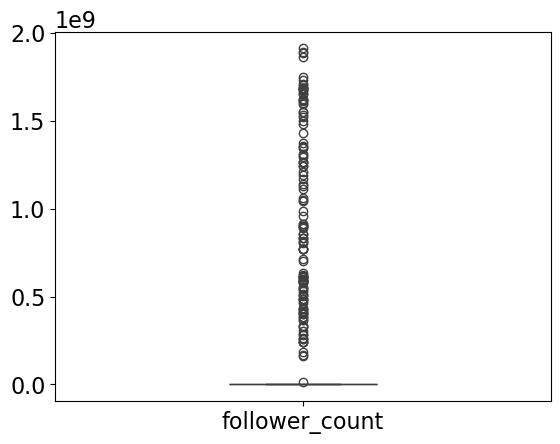

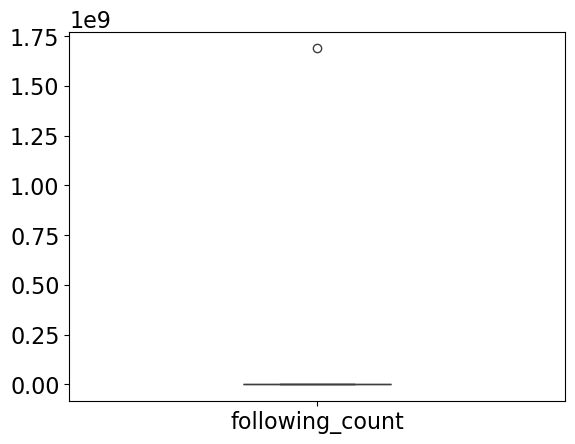

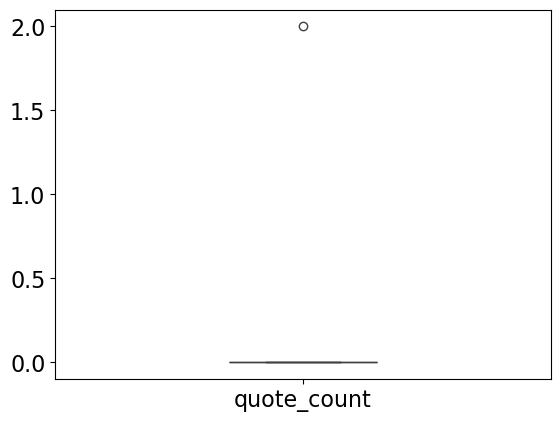

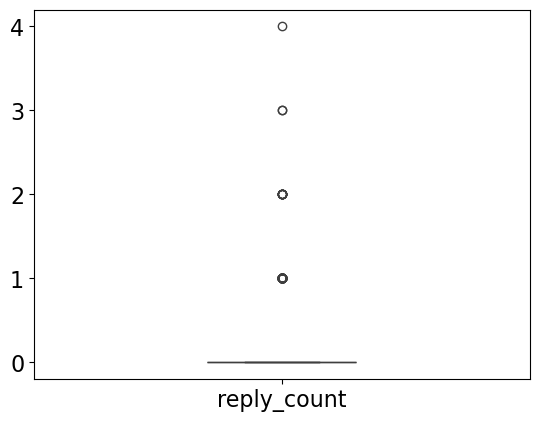

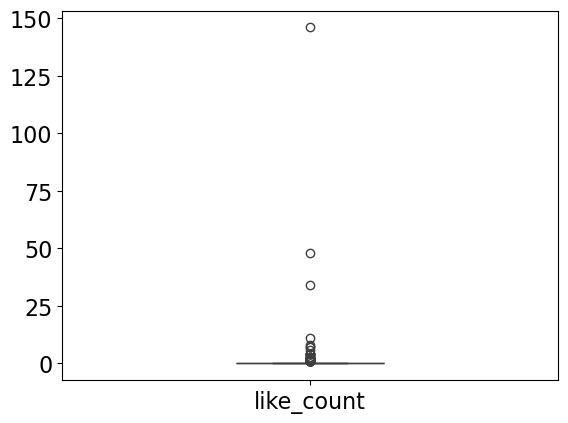

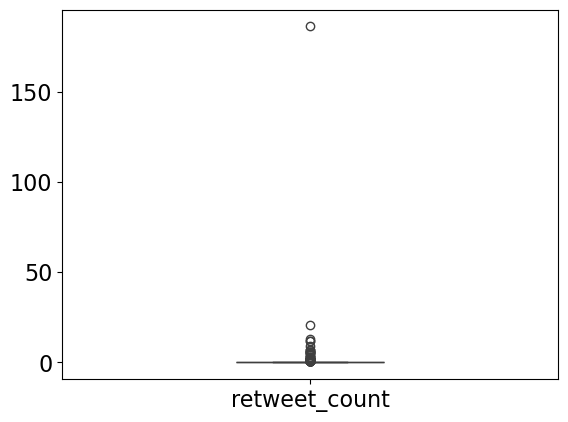

In [97]:
#plt = df.select(df.columns).toPandas().boxplot(df.columns, fontsize='small', figsize=(20,7))

def show_boxplot(df):
    for column in df.columns:
        if df.schema[column].dataType == IntegerType():
            column_df = df.select(column).toPandas()
            sns.boxplot(column_df, width = 0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)

Выбросы до их удаления (строки):

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127826 (\N{CHERRIES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12288 (\N{IDEOGRAPHIC SPACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128511 (\N{MOYAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128144 (\N{BOUQUET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarn

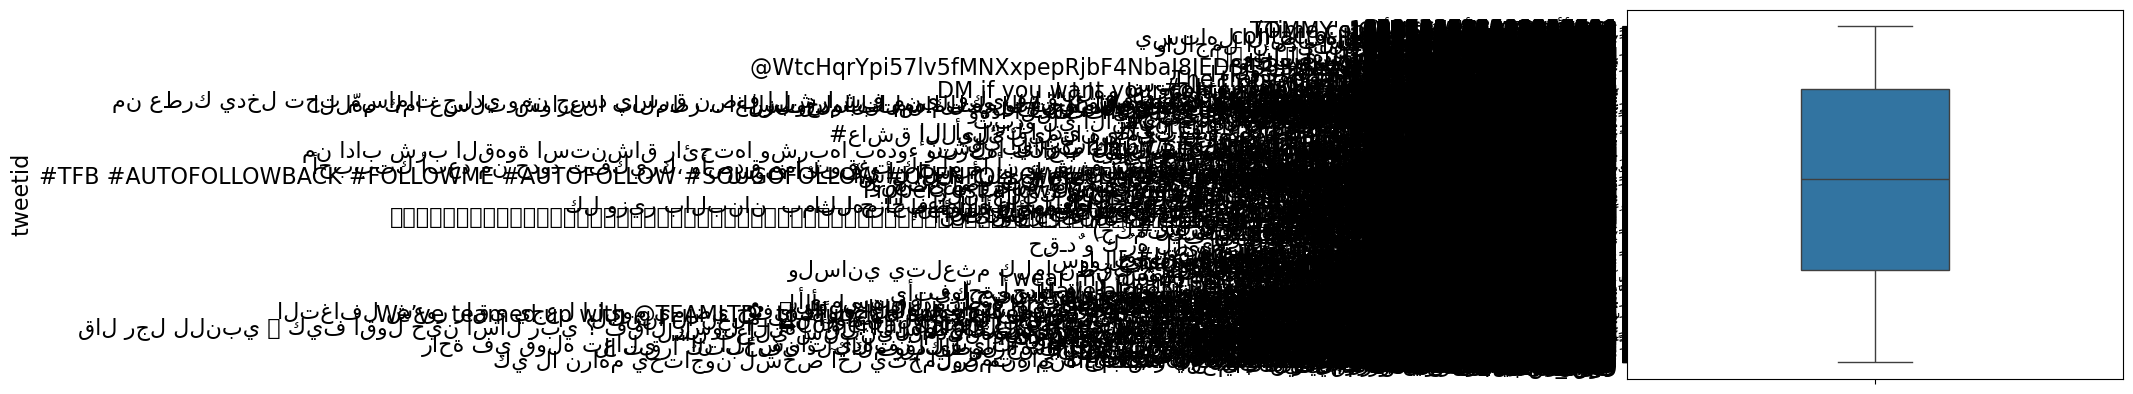

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128179 (\N{CREDIT CARD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128139 (\N{KISS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


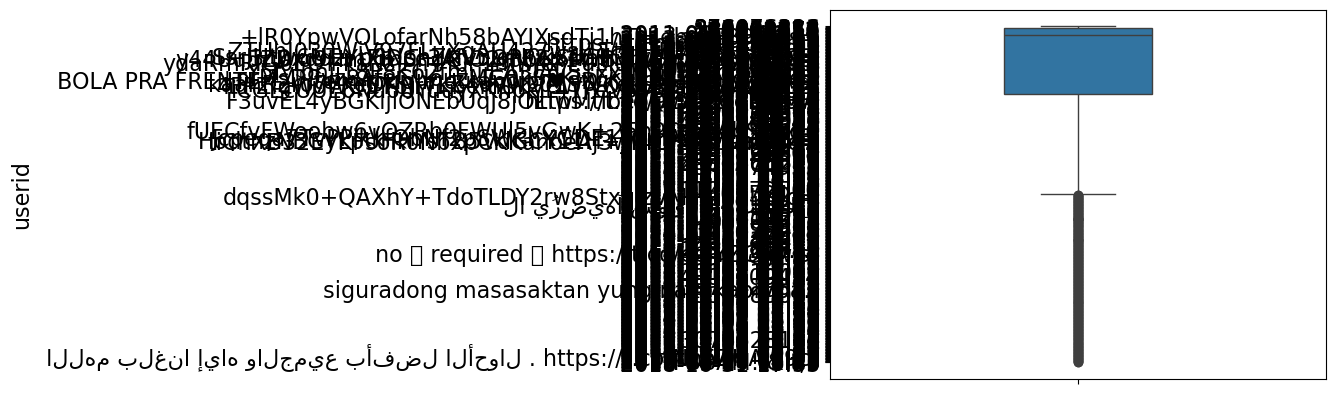

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 120025 (\N{MATHEMATICAL BOLD SCRIPT CAPITAL J}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128139 (\N{KISS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/sit

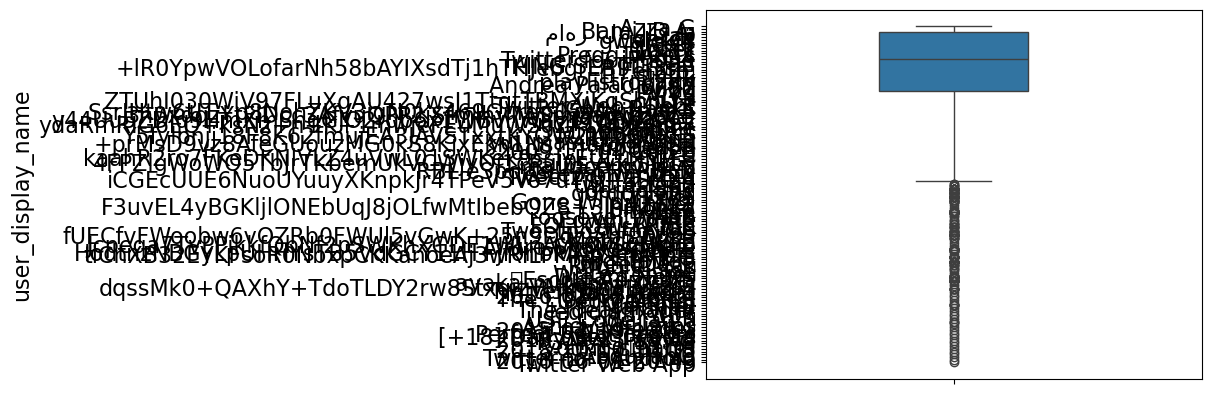

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


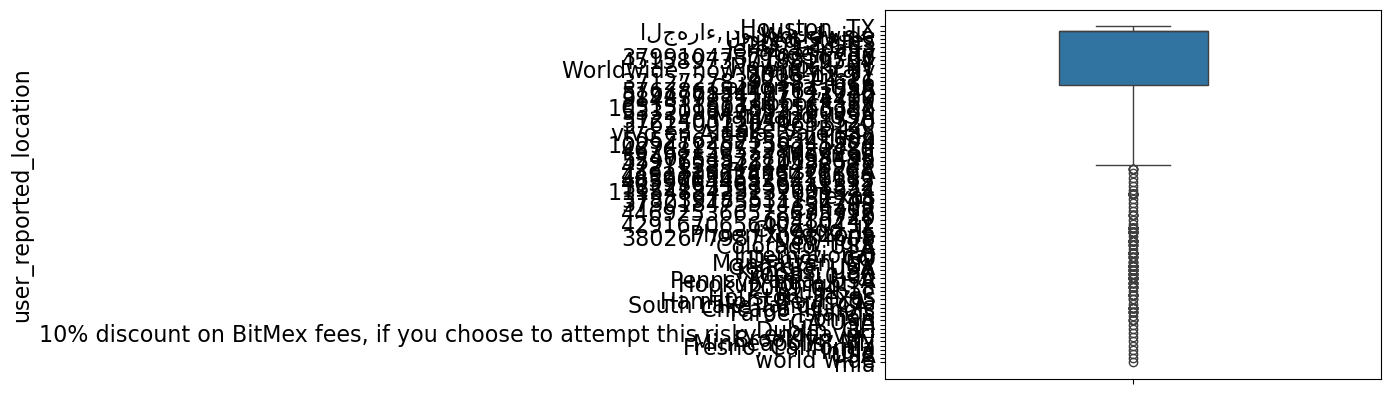

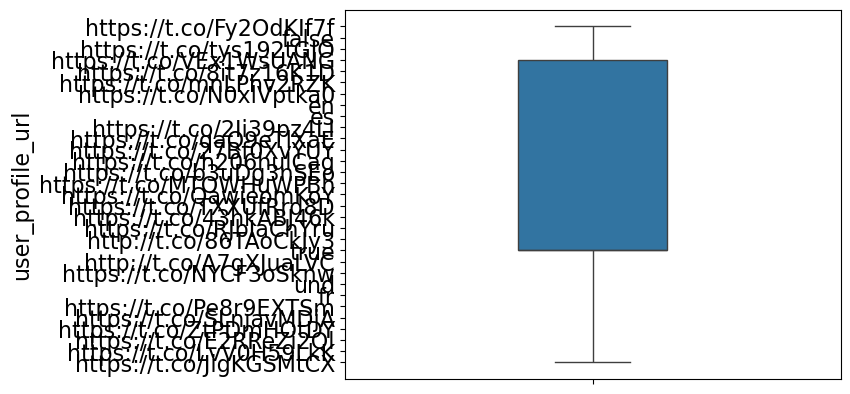

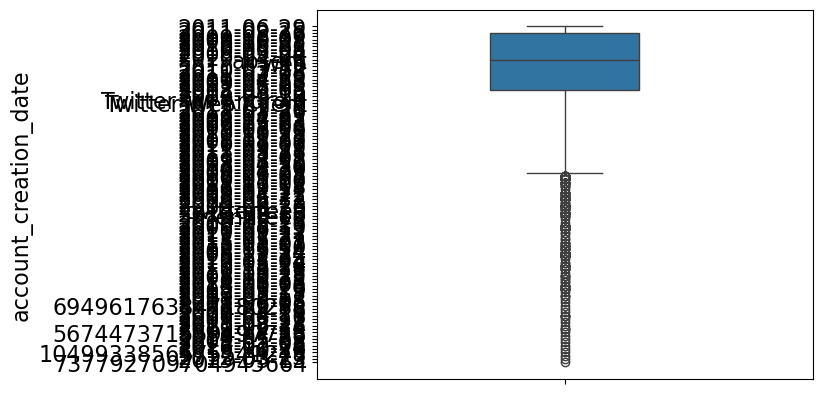

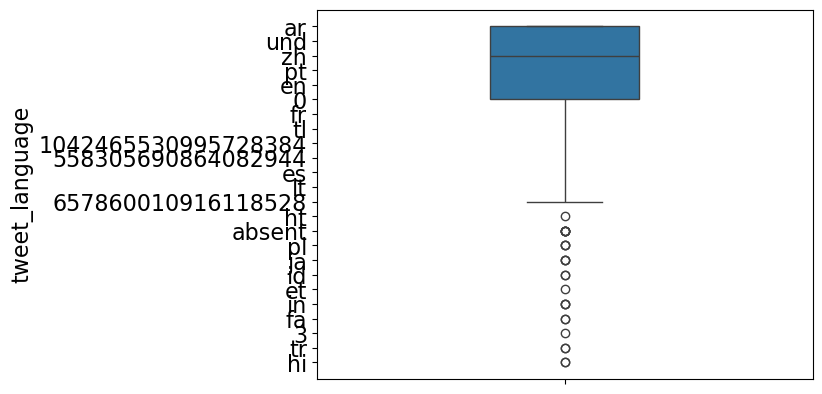

In [98]:
import seaborn as sns

def show_boxplot(df):
    for column in df.columns: 
        if df.schema[column].dataType == StringType():  # Проверяем тип данных столбца
            column_df = df.select(column).toPandas()
            sns.boxplot(y=column, data=column_df, width=0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)


In [99]:
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean
df = df.dropna(subset=['tweetid'])
df = df.dropna(subset=['userid'])
df = df.dropna(subset=['user_display_name'])
df = df.dropna(subset=['user_reported_location'])
df = df.dropna(subset=['user_profile_url'])
df = df.dropna(subset=['is_retweet'])
df = df.dropna(subset=['tweet_language'])
df = df.dropna(subset=['account_creation_date'])
avg_value = df.select(mean('follower_count')).collect()[0]['avg(follower_count)']
df = df.withColumn('follower_count', 
                    when((col('follower_count').isin([None,np.nan])) | (col('follower_count').isNull()),
                        avg_value).otherwise(col('follower_count')))

avg_value = df.select(mean('following_count')).collect()[0]['avg(following_count)']
df = df.withColumn('following_count', 
                    when((col('following_count').isin([None,np.nan])) | (col('following_count').isNull()),
                        avg_value).otherwise(col('following_count')))

avg_value = df.select(mean('quote_count')).collect()[0]['avg(quote_count)']
df = df.withColumn('quote_count', 
                    when((col('quote_count').isin([None,np.nan])) | (col('quote_count').isNull()),
                        avg_value).otherwise(col('quote_count')))

avg_value = df.select(mean('reply_count')).collect()[0]['avg(reply_count)']
df = df.withColumn('reply_count', 
                    when((col('reply_count').isin([None,np.nan])) | (col('reply_count').isNull()),
                        avg_value).otherwise(col('reply_count')))

avg_value = df.select(mean('like_count')).collect()[0]['avg(like_count)']
df = df.withColumn('like_count', 
                    when((col('like_count').isin([None,np.nan])) | (col('like_count').isNull()),
                        avg_value).otherwise(col('like_count')))

avg_value = df.select(mean('retweet_count')).collect()[0]['avg(retweet_count)']
df = df.withColumn('retweet_count', 
                    when((col('retweet_count').isin([None,np.nan])) | (col('retweet_count').isNull()),
                        avg_value).otherwise(col('retweet_count')))

print('Elimination of missing values was successful')

Elimination of missing values was successful


In [100]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

tweetid  userid  user_display_name  user_reported_location  \
0        0       0                  0                       0   

   user_profile_url  follower_count  following_count  account_creation_date  \
0                 0               0                0                      0   

   tweet_language  is_retweet  quote_count  reply_count  like_count  \
0               0           0            0            0           0   

   retweet_count  
0              0

Графики выбросов (только для чисел)

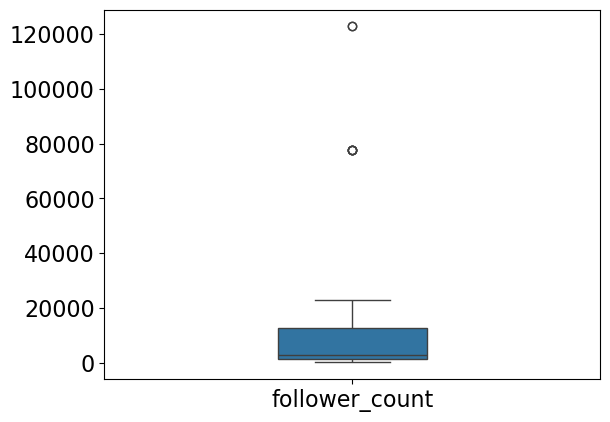

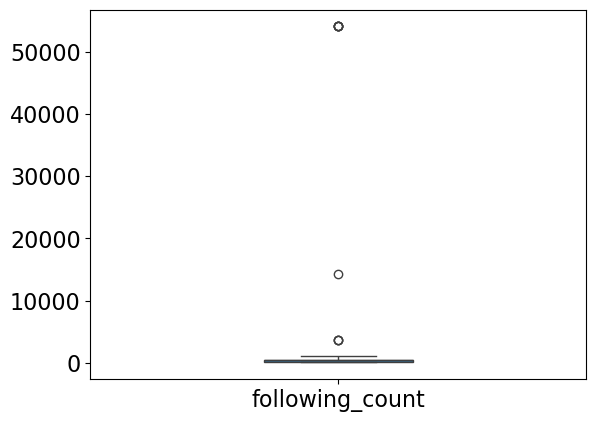

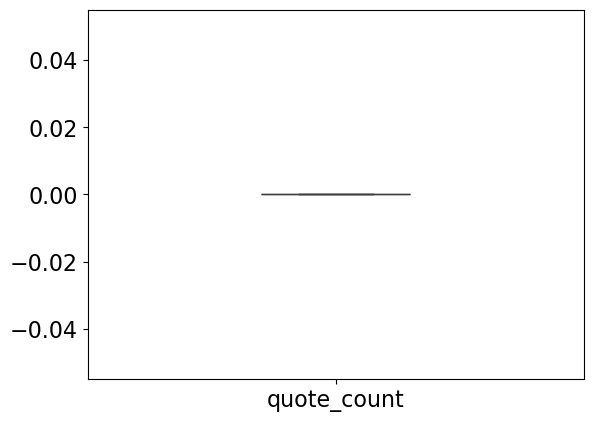

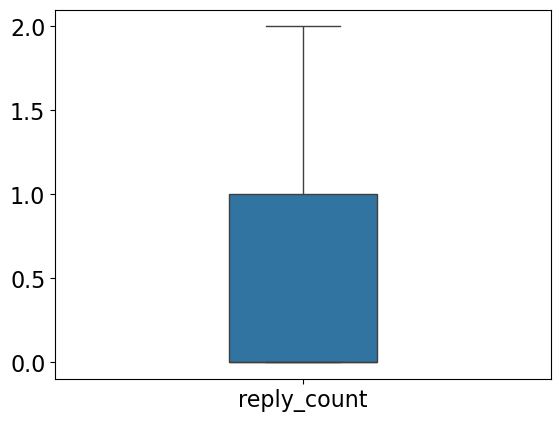

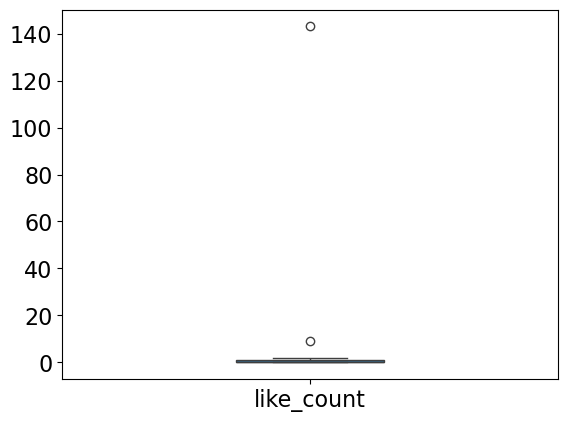

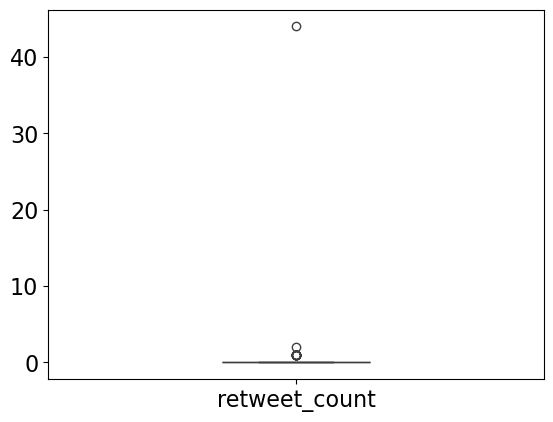

In [101]:
import seaborn as sns

def show_boxplot(df):
    for column in df.columns:
        if df.schema[column].dataType == DoubleType():
            column_df = df.select(column).toPandas()
            sns.boxplot(column_df, width = 0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)

Графики выбросов (только для строк):

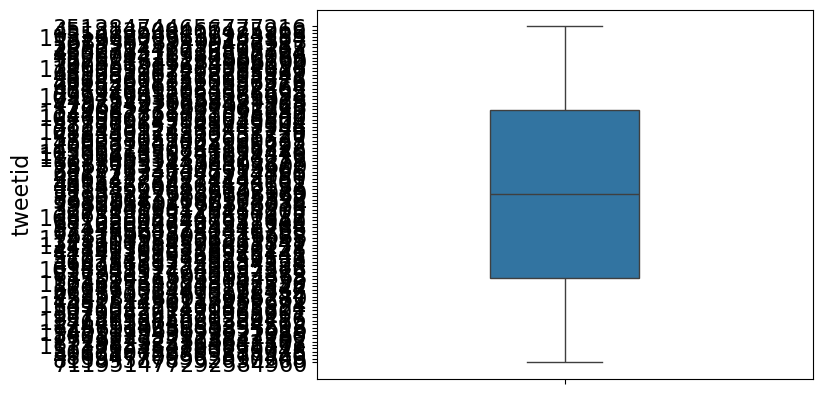

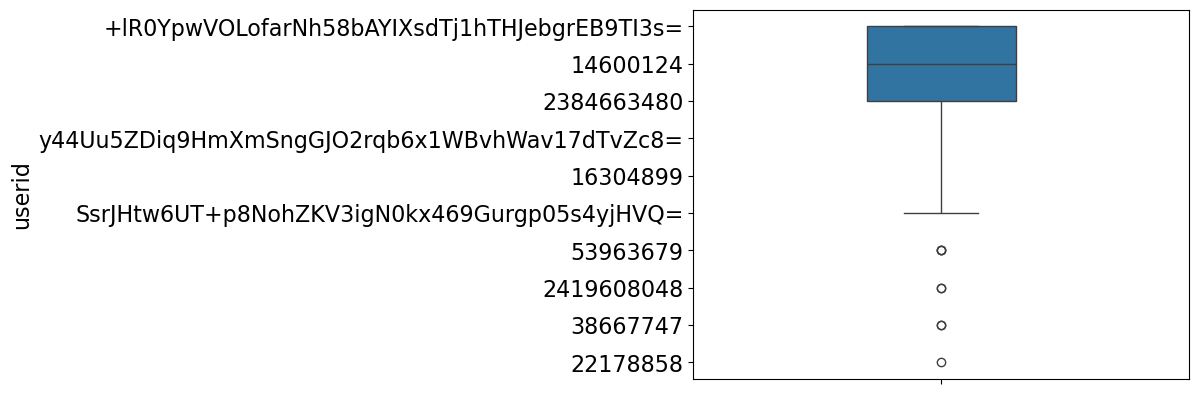

/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127470 (\N{REGIONAL INDICATOR SYMBOL LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127481 (\N{REGIONAL INDICATOR SYMBOL LETTER T}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


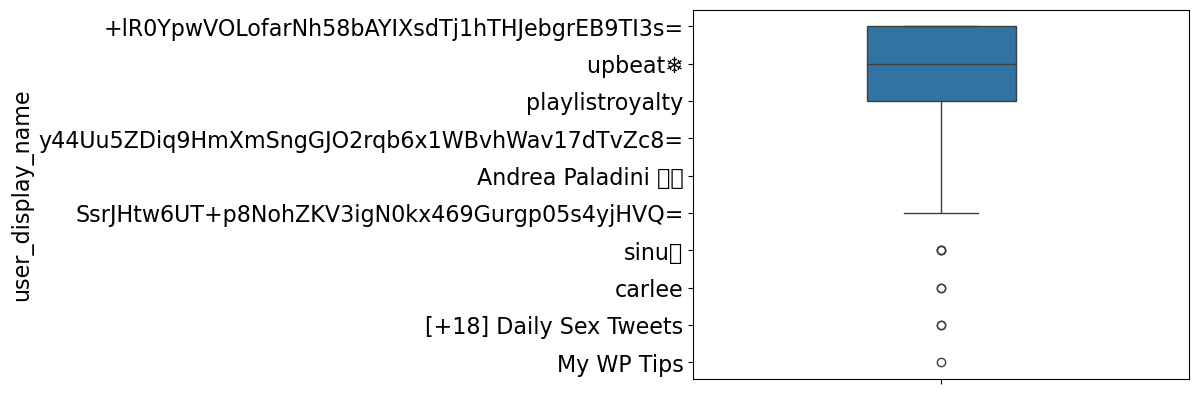

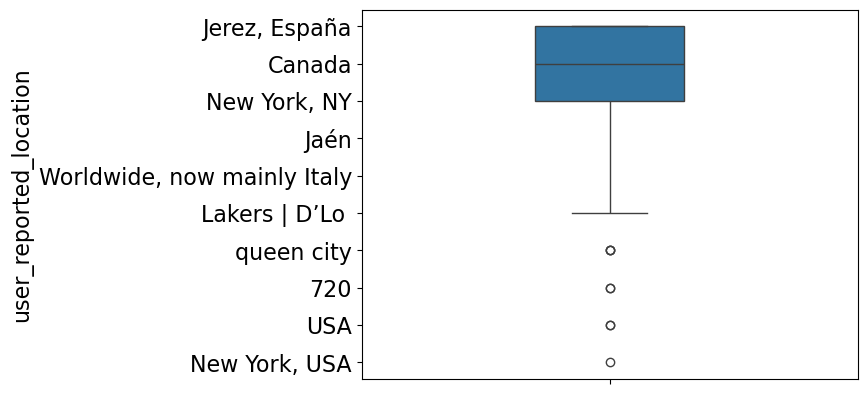

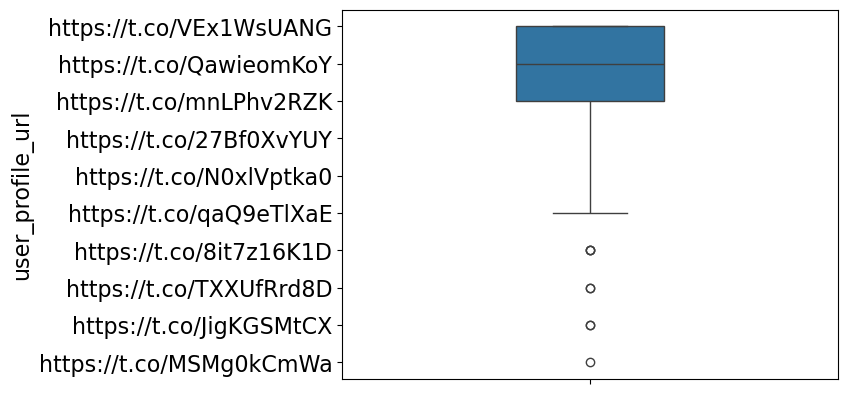

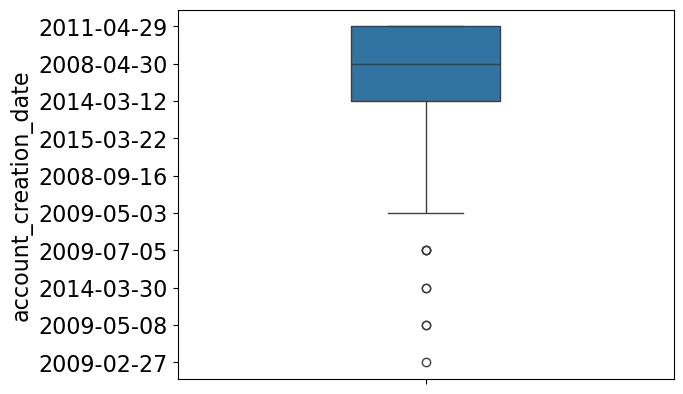

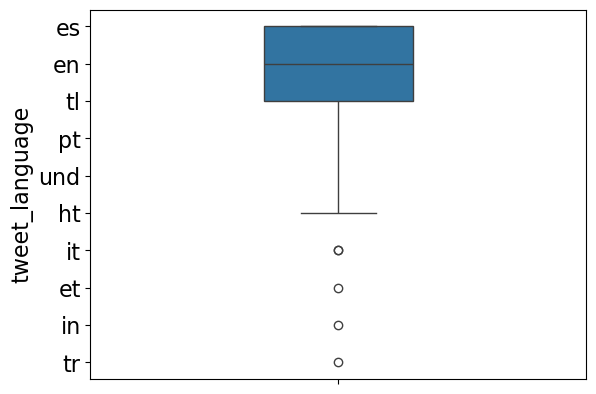

In [102]:
import seaborn as sns

def show_boxplot(df):
    for column in df.columns: 
        if df.schema[column].dataType == StringType():  # Проверяем тип данных столбца
            column_df = df.select(column).toPandas()
            sns.boxplot(y=column, data=column_df, width=0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)


In [103]:
df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

summary     follower_count    following_count          quote_count  \
0   count             101504             101504               101504   
1    mean  18359.01404140414  5190.861396139583  0.05453738091393518   
2  stddev  35602.69746214258  14495.85596749563      3.5549193940102   
3     min               14.0               14.0                  0.0   
4     max           274276.0            54047.0               1042.0   

           reply_count          like_count       retweet_count  
0               101504              101504              101504  
1  0.34730744388825874  6.2200367350234265  1.4869207169384815  
2   1.1274800708957033  105.48315325310857   27.19648559278667  
3                  0.0                 0.0                 0.0  
4                146.0              9014.0              2267.0

Межквартильный интервал для избавления от выбросов:

In [104]:
from pyspark.sql.functions import col

outlier_columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']

for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(col(column).between(lower_bound, upper_bound))

df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

summary      follower_count     following_count quote_count  \
0   count               68684               68684       68684   
1    mean   6223.303884456351  353.74686972220604         0.0   
2  stddev  6536.1049492733055  253.39284451780645         0.0   
3     min                14.0                14.0         0.0   
4     max             22948.0              1099.0         0.0   

           reply_count          like_count retweet_count  
0                68684               68684         68684  
1  0.28893192009783936  0.3113680041931163           0.0  
2  0.49626454389485325  0.5641715956216876           0.0  
3                  0.0                 0.0           0.0  
4                  2.0                 2.0           0.0

In [105]:
df = df.withColumn("is_retweet", col("is_retweet").cast(StringType()))
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 20 data rows:')
df.limit(20).toPandas()

Data overview
root
 |-- tweetid: string (nullable = true)
 |-- userid: string (nullable = true)
 |-- user_display_name: string (nullable = true)
 |-- user_reported_location: string (nullable = true)
 |-- user_profile_url: string (nullable = true)
 |-- follower_count: double (nullable = true)
 |-- following_count: double (nullable = true)
 |-- account_creation_date: string (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: string (nullable = true)
 |-- quote_count: double (nullable = true)
 |-- reply_count: double (nullable = true)
 |-- like_count: double (nullable = true)
 |-- retweet_count: double (nullable = true)

Columns overview


Column Name Data type
0                  tweetid    string
1                   userid    string
2        user_display_name    string
3   user_reported_location    string
4         user_profile_url    string
5           follower_count    double
6          following_count    double
7    account_creation_date    string
8           tweet_language    string
9               is_retweet    string
10             quote_count    double
11             reply_count    double
12              like_count    double
13           retweet_count    double

Data frame describe (string and numeric columns only):


summary                 tweetid  \
0   count                   68684   
1    mean    6.321654084105911E17   
2  stddev  2.39986391345632352E17   
3     min     1000102224184430592   
4     max      999883584881156098   

                                         userid  \
0                                         68684   
1                           2.196796558006647E9   
2                            6.36099241754219E8   
3  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
4  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   

                              user_display_name user_reported_location  \
0                                         68684                  68684   
1                                          None                  720.0   
2                                          None                    0.0   
3  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=                    720   
4  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=           New York, NY   

          user_profile_url      follower_count     following_count  \
0                    68684               68684               68684   
1                     None   6223.303884456351  353.74686972220604   
2                     None  6536.1049492733055  253.39284451780645   
3   http://t.co/x5d1cn62s3                14.0                14.0   
4  https://t.co/qb7acu9FU2             22948.0              1099.0   

  account_creation_date tweet_language is_retweet quote_count  \
0                 68684          68684      68684       68684   
1                  None           None       None         0.0   
2                  None           None       None         0.0   
3            2008-04-30             ar      false         0.0   
4            2015-03-22             vi       true         0.0   

           reply_count          like_count retweet_count  
0                68684               68684         68684  
1  0.28893192009783936  0.3113680041931163           0.0  
2  0.49626454389485325  0.5641715956216876           0.0  
3                  0.0                 0.0           0.0  
4                  2.0                 2.0           0.0

There are total 68684 row, Let print first 20 data rows:


tweetid                                        userid  \
0    643700814498955264  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
1    953052215857569793  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
2   1006138490537627648  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
3    963206327685218304  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
4   1145520251020414976  SsrJHtw6UT+p8NohZKV3igN0kx469Gurgp05s4yjHVQ=   
5   1080666516880674816                                     485316109   
6    862973707580567552  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
7   1009401632046702594  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
8    842088808233476096  y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
9   1138289112551698432  SsrJHtw6UT+p8NohZKV3igN0kx469Gurgp05s4yjHVQ=   
10   738011837367648257                                    2384663480   
11   489052508354924545                                    2384663480   
12   482565265775812609                                    2384663480   
13   518779543729889282                                    2384663480   
14   482775843815444481                                    2384663480   
15   743445929743777792  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
16   755138123395395585  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
17   543765409833705472  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
18   386466656333352960  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
19   389398933463502848  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   

                               user_display_name  \
0   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
1   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
2   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
3   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
4   SsrJHtw6UT+p8NohZKV3igN0kx469Gurgp05s4yjHVQ=   
5                                   Basement ORG   
6   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
7   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
8   y44Uu5ZDiq9HmXmSngGJO2rqb6x1WBvhWav17dTvZc8=   
9   SsrJHtw6UT+p8NohZKV3igN0kx469Gurgp05s4yjHVQ=   
10                               playlistroyalty   
11                               playlistroyalty   
12                               playlistroyalty   
13                               playlistroyalty   
14                               playlistroyalty   
15  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
16  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
17  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
18  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   
19  +lR0YpwVOLofarNh58bAYIXsdTj1hTHJebgrEB9TI3s=   

                               user_reported_location  \
0                                                Jaén   
1                                                Jaén   
2                                                Jaén   
3                                                Jaén   
4                                      Lakers | D’Lo    
5   Flar3Fir3 | JitsuLeon | Cloud_Chsr | Lolnani |...   
6                                                Jaén   
7                                                Jaén   
8                                                Jaén   
9                                      Lakers | D’Lo    
10                                       New York, NY   
11                                       New York, NY   
12                                       New York, NY   
13                                       New York, NY   
14                                       New York, NY   
15                                      Jerez, España   
16                                      Jerez, España   
17                                      Jerez, España   
18                                      Jerez, España   
19                                      Jerez, España   

           user_profile_url  follower_count  following_count  \
0   https://t.co/27Bf0XvYUY           108.0            356.0   
1   https://t.co/27Bf0XvYUY           108.0            356.0   

Проверка выбросов после применения межквательного интервала - double

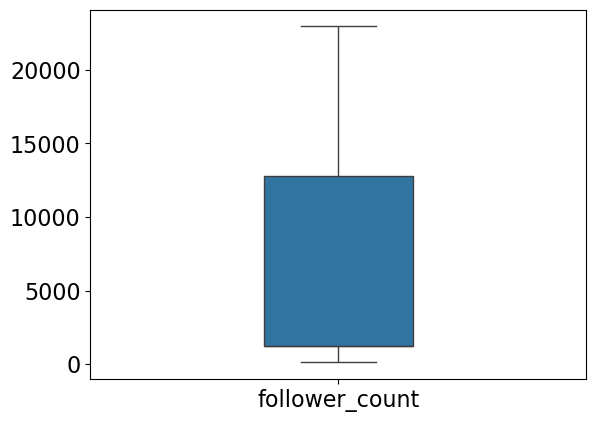

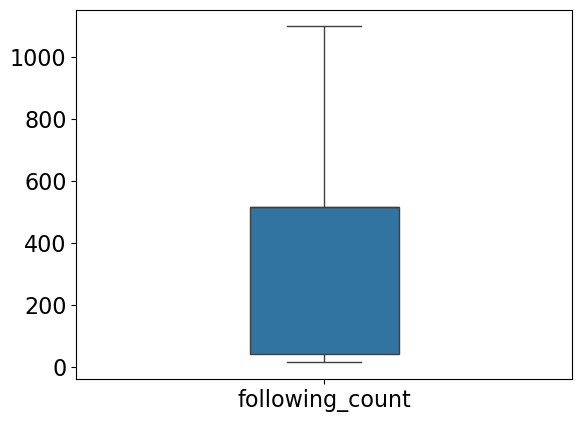

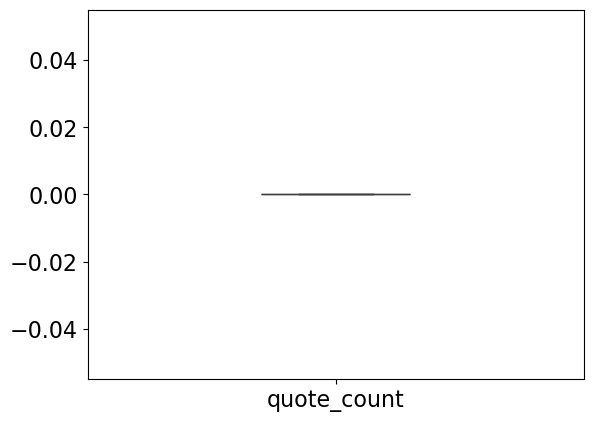

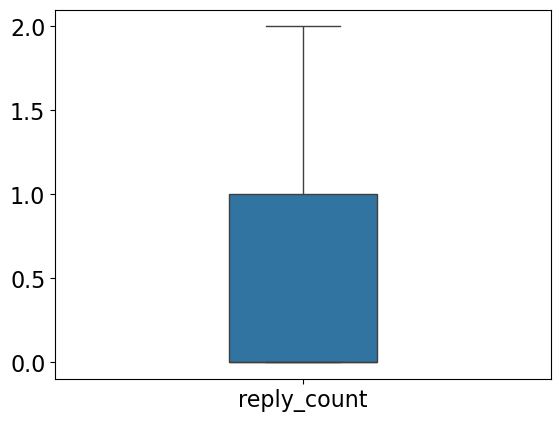

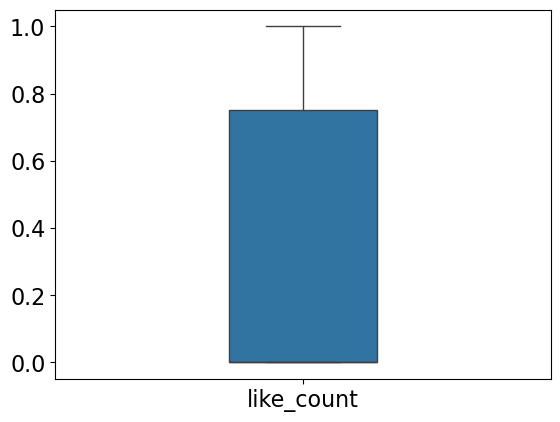

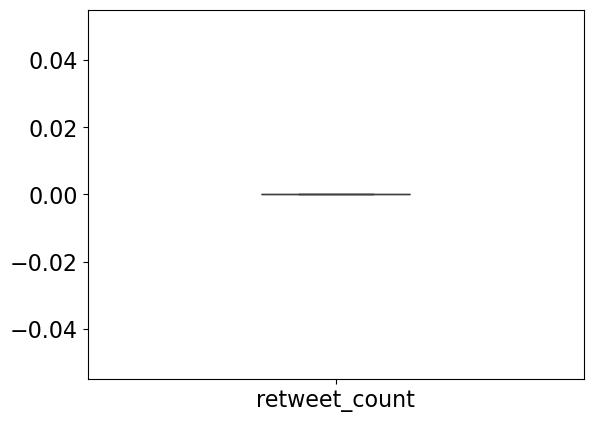

In [106]:
import seaborn as sns

def show_boxplot(df):
    for column in df.columns:
        if df.schema[column].dataType == DoubleType():
            column_df = df.select(column).toPandas()
            sns.boxplot(column_df, width = 0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)

Проверка выбросов после применения межквательного интервала - string

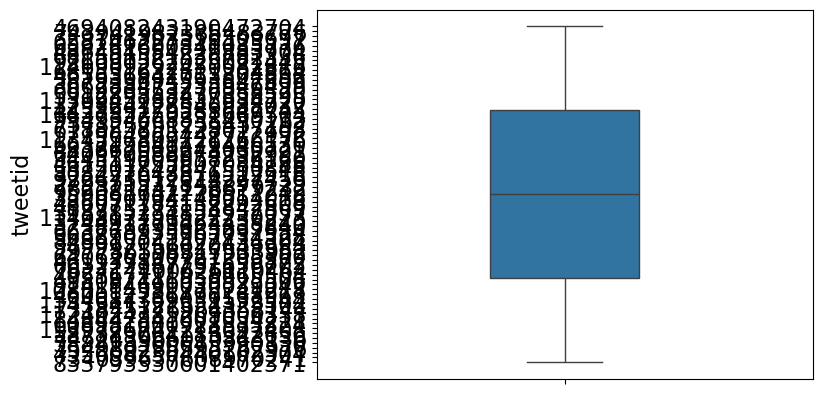

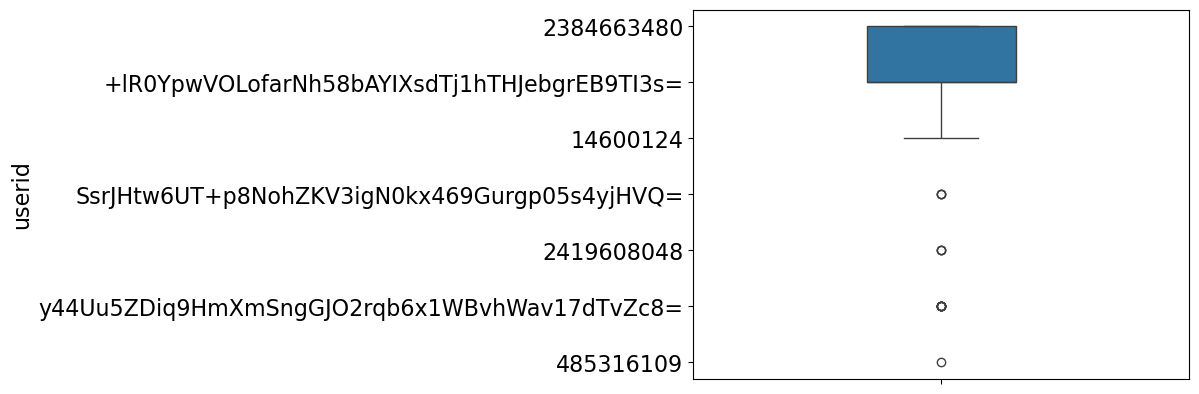

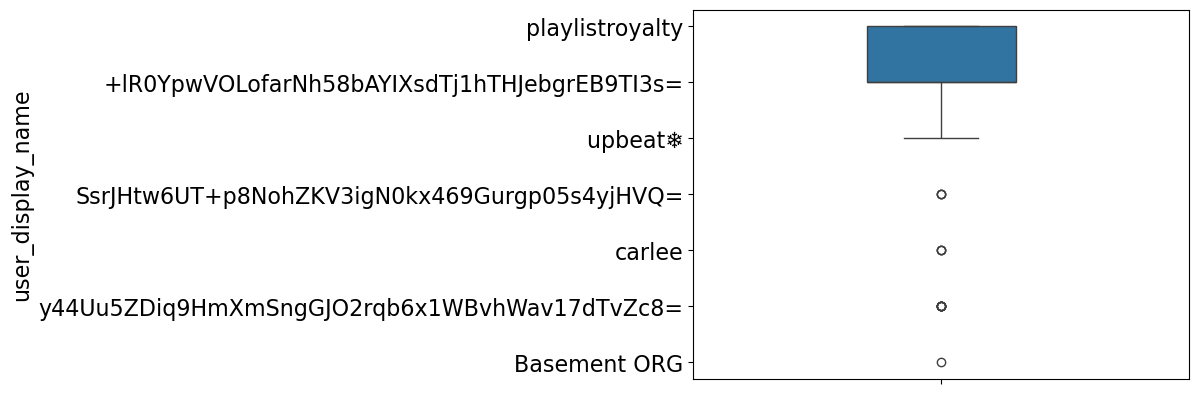

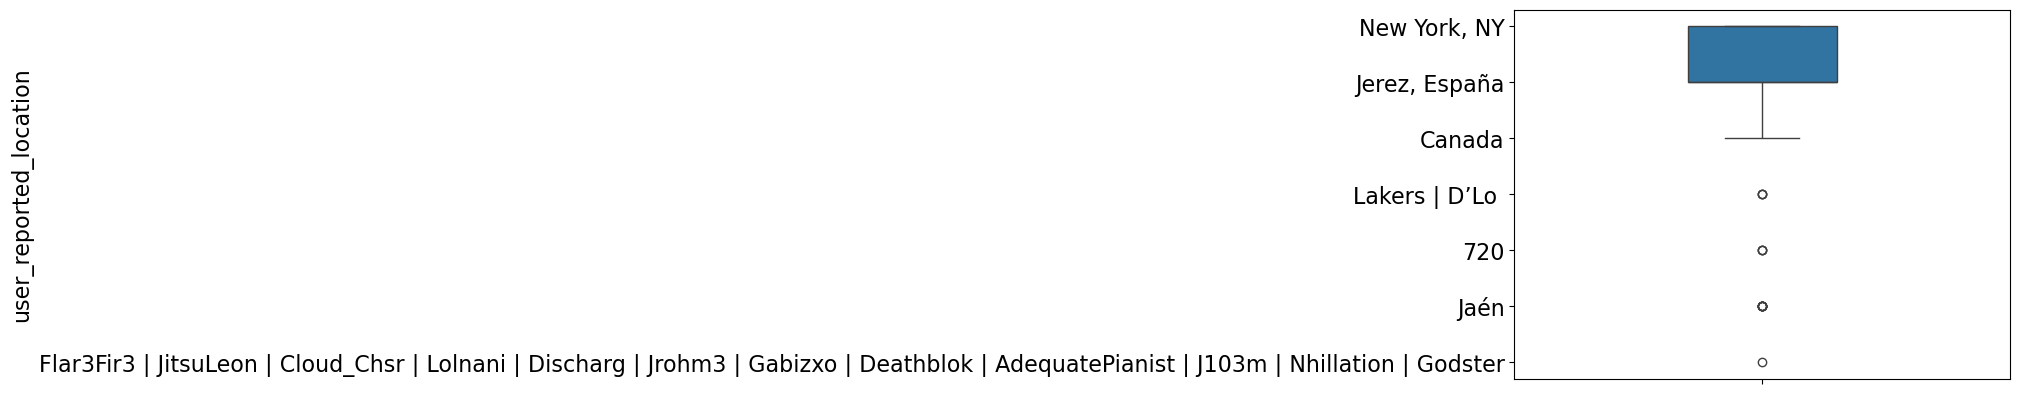

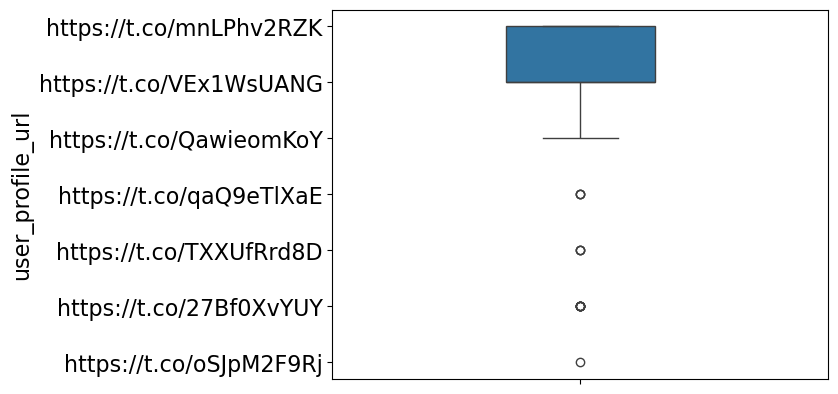

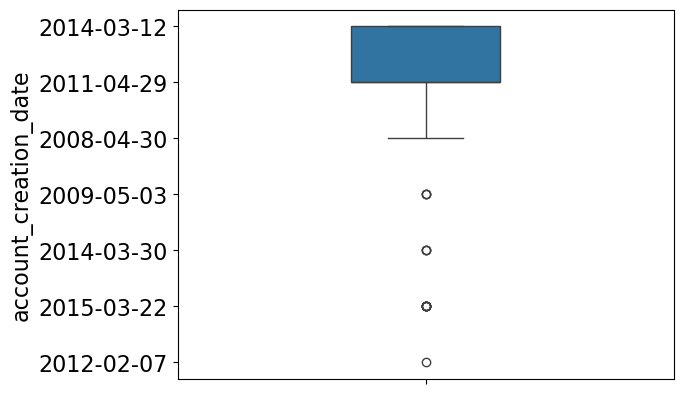

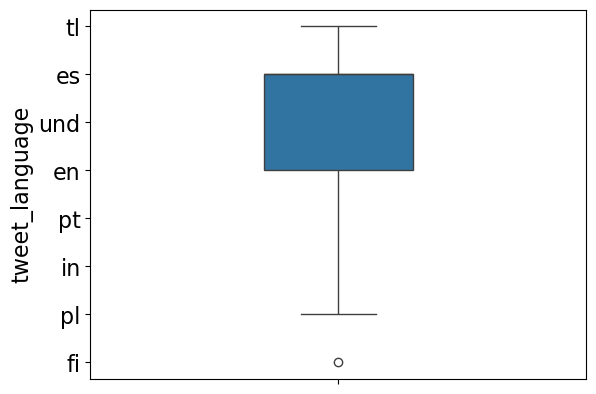

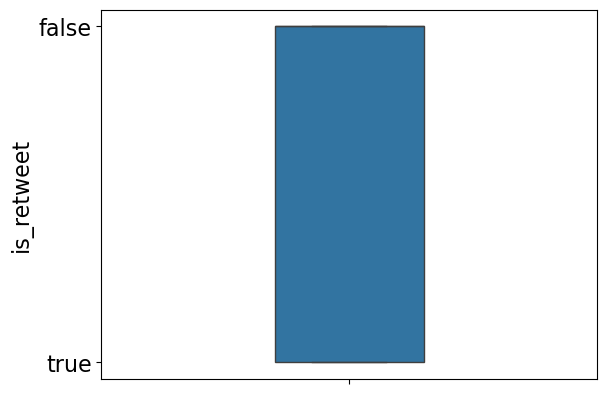

In [107]:
import seaborn as sns

def show_boxplot(df):
    for column in df.columns: 
        if df.schema[column].dataType == StringType():  # Проверяем тип данных столбца
            column_df = df.select(column).toPandas()
            sns.boxplot(y=column, data=column_df, width=0.3)
            plt.show()

df_sample = df.sample(True, 0.001, 1)
show_boxplot(df_sample)


Вывод 5 местоположений(дат) по публикации твитов

Top 5 tweet countries:


/tmp/ipykernel_106/1539595466.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')


user_reported_location  count  percentage
0          Jerez, España  35506   51.694718
1           New York, NY  22466   32.709219
2                   Jaén   3829    5.574806
3                    720   2223    3.236562
4         Lakers | D’Lo    2026    2.949741
0                 others   2634    3.834954

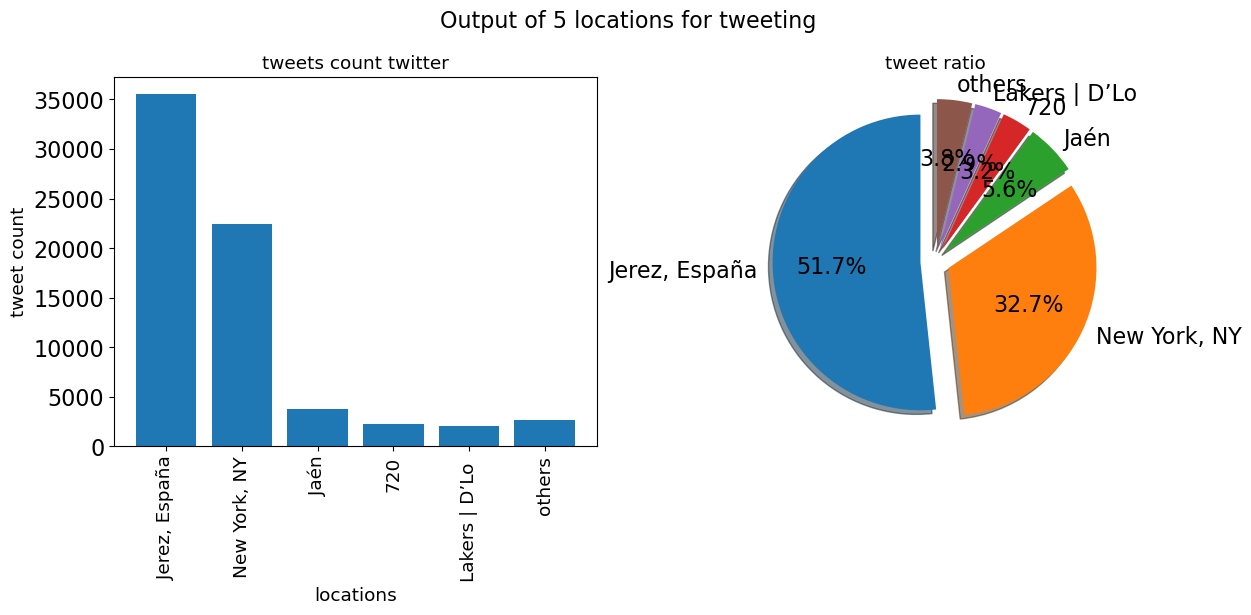

In [108]:
total_twitter_count = df.count()
highest_twitter_df = df.select(df.user_reported_location) \
    .groupBy(df.user_reported_location) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()


highest_twitter_df['percentage'] = highest_twitter_df['count'] \
    / total_twitter_count * 100

others = {
    'user_reported_location': 'others', 
    'count': total_twitter_count - np.sum(highest_twitter_df['count']), 
    'percentage': 100 - np.sum(highest_twitter_df['percentage'])
}

highest_twitter_df = pd.concat([highest_twitter_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_twitter_df['user_reported_location'], height=highest_twitter_df['count'])
title0 = axs[0].set_title('tweets count twitter', fontsize='small')
xlabel0 = axs[0].set_xlabel('locations', fontsize='small')
ylabel0 = axs[0].set_ylabel('tweet count', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_twitter_df['user_reported_location'], rotation='vertical', fontsize='small')
explode = (0.1,) * len(highest_twitter_df['user_reported_location'])
title1 = axs[1].set_title('tweet ratio', fontsize='small')
plot1 = axs[1].pie(x=highest_twitter_df['percentage'],
                   labels=highest_twitter_df['user_reported_location'],
                   autopct='%1.1f%%',
                   shadow=True,
                   explode=explode,
                   startangle=90,
                   radius=1)

print('Top 5 tweet countries:')
highest_twitter_df

text = fig.text(0.5, 1.02, 'Output of 5 locations for tweeting', ha='center', va='top', transform=fig.transFigure)

Диграмма распределения местоположений(дат) твитов в зависимости является это ли ретвитом или нет. Т.к. мой датафрейм "избитый", в колонке "user_reported_location"
находятся данные далеко не похожие на местоположение.

/tmp/ipykernel_106/983870098.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  a = fig.tight_layout()


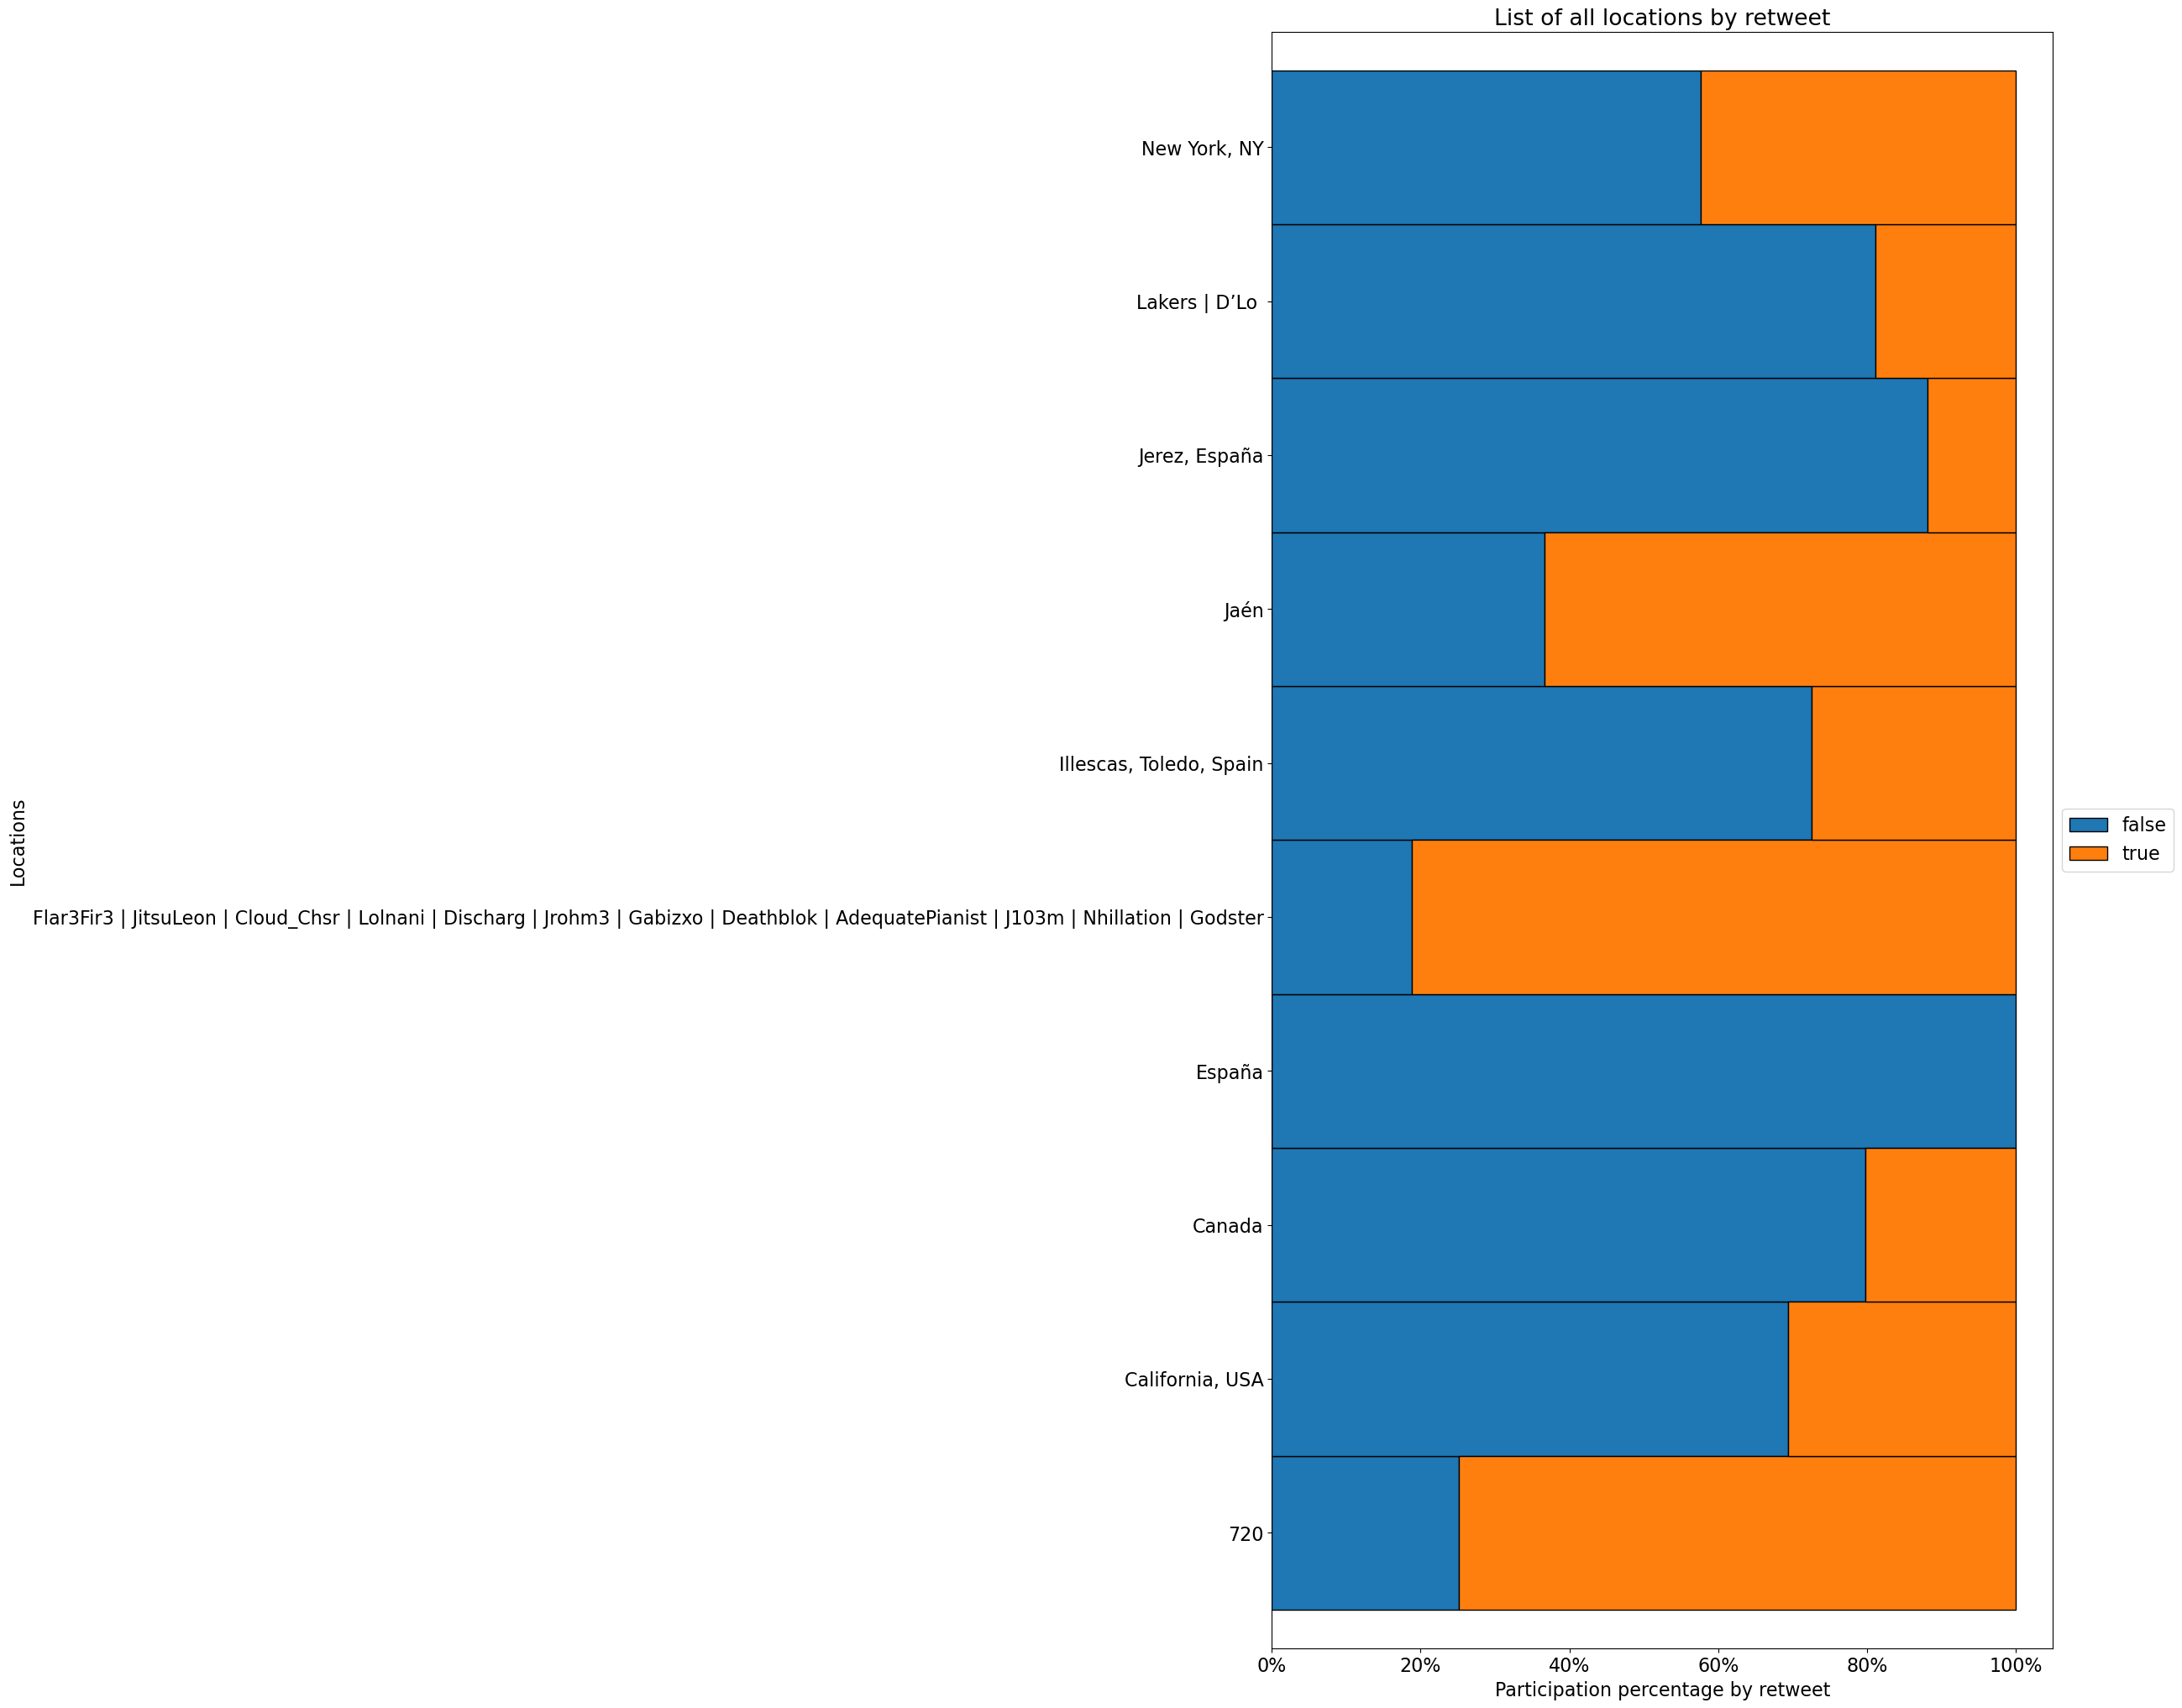

In [109]:
location_by_retweet_df = df.groupBy(df.user_reported_location, df.is_retweet).count().toPandas()

is_retweet = location_by_retweet_df['is_retweet'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = location_by_retweet_df.groupby(['user_reported_location', 'is_retweet'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all locations by retweet')
ylabel = plt.ylabel('Locations');
xlabel = plt.xlabel('Participation percentage by retweet');
legend = plt.legend(
    sorted(is_retweet), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 20});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

Находим 10 популярных местоположений(дат) с наличиями или отсуствием ретвитов:

In [110]:
is_retweet_list = ['false', 'true']  # измененное имя списка

location_by_retweet_df = df.groupBy(df.user_reported_location, df.is_retweet).count().toPandas().pivot_table(
    index="user_reported_location", columns="is_retweet", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1) \

location_by_retweet_df['all'] = 0
for is_retweet in is_retweet_list:  # изменено имя итератора цикла
    location_by_retweet_df['all'] += location_by_retweet_df[is_retweet]

location_by_retweet_df['percent'] = location_by_retweet_df['all'] / np.sum(location_by_retweet_df['all']) * 100

for is_retweet in is_retweet_list:  # изменено имя итератора цикла
    location_by_retweet_df['percent ' + is_retweet + ' retweets'] = \
        (location_by_retweet_df[is_retweet] / location_by_retweet_df['all']) * 100

location_by_retweet_df = location_by_retweet_df.sort_values(
    by='percent', ascending=False
).head(10)

others = {'is_retweet' : 'others'}
for column in [*['all', 'percent'], *is_retweet_list,]:
    value = np.sum(location_by_retweet_df[column]) - np.sum(location_by_retweet_df[column])
    others.update({column: value})

for is_retweet in is_retweet_list:  # изменено имя итератора цикла
    value = (others[is_retweet] / others['all']) * 100
    others.update({'percent ' + is_retweet  + ' retweets': value})

location_by_retweet_df = pd.concat([location_by_retweet_df,pd.DataFrame.from_dict([others])]) \
                                .reset_index(drop=True)

# Удаление последней колонки "is_retweet"
location_by_retweet_df = location_by_retweet_df.drop("is_retweet", axis=1)

# Удаление последней строки "nan"
location_by_retweet_df = location_by_retweet_df.dropna()

location_by_retweet_df


/tmp/ipykernel_106/776439066.py:28: RuntimeWarning: invalid value encountered in scalar divide
  value = (others[is_retweet] / others['all']) * 100


user_reported_location  false  true    all  \
0                                      Jerez, España  31280  4226  35506   
1                                       New York, NY  12944  9522  22466   
2                                               Jaén   1402  2427   3829   
3                                                720    559  1664   2223   
4                                     Lakers | D’Lo    1644   382   2026   
5                                             Canada   1468   371   1839   
6                            Illescas, Toledo, Spain    275   104    379   
7  Flar3Fir3 | JitsuLeon | Cloud_Chsr | Lolnani |...     62   267    329   
8                                    California, USA     50    22     72   
9                                             España     15     0     15   

     percent  percent false retweets  percent true retweets  
0  51.694718               88.097786              11.902214  
1  32.709219               57.615953              42.384047  
2   5.574806               36.615304              63.384696  
3   3.236562               25.146199              74.853801  
4   2.949741               81.145114              18.854886  
5   2.677479               79.825992              20.174008  
6   0.551802               72.559367              27.440633  
7   0.479005               18.844985              81.155015  
8   0.104828               69.444444              30.555556  
9   0.021839              100.000000               0.000000

Сортируем данные о ретвитах из выше описанной таблицы в которых больше всего ретвитов

In [111]:
true_location_by_retweet_df = location_by_retweet_df.sort_values(
    by='percent true retweets', ascending=False
).head(10).reset_index(drop=True)

true_location_by_retweet_df

user_reported_location  false  true    all  \
0  Flar3Fir3 | JitsuLeon | Cloud_Chsr | Lolnani |...     62   267    329   
1                                                720    559  1664   2223   
2                                               Jaén   1402  2427   3829   
3                                       New York, NY  12944  9522  22466   
4                                    California, USA     50    22     72   
5                            Illescas, Toledo, Spain    275   104    379   
6                                             Canada   1468   371   1839   
7                                     Lakers | D’Lo    1644   382   2026   
8                                      Jerez, España  31280  4226  35506   
9                                             España     15     0     15   

     percent  percent false retweets  percent true retweets  
0   0.479005               18.844985              81.155015  
1   3.236562               25.146199              74.853801  
2   5.574806               36.615304              63.384696  
3  32.709219               57.615953              42.384047  
4   0.104828               69.444444              30.555556  
5   0.551802               72.559367              27.440633  
6   2.677479               79.825992              20.174008  
7   2.949741               81.145114              18.854886  
8  51.694718               88.097786              11.902214  
9   0.021839              100.000000               0.000000

Находим популярные местоположений(даты) с разными языками твитов

/tmp/ipykernel_106/1970292505.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  a = fig.tight_layout()


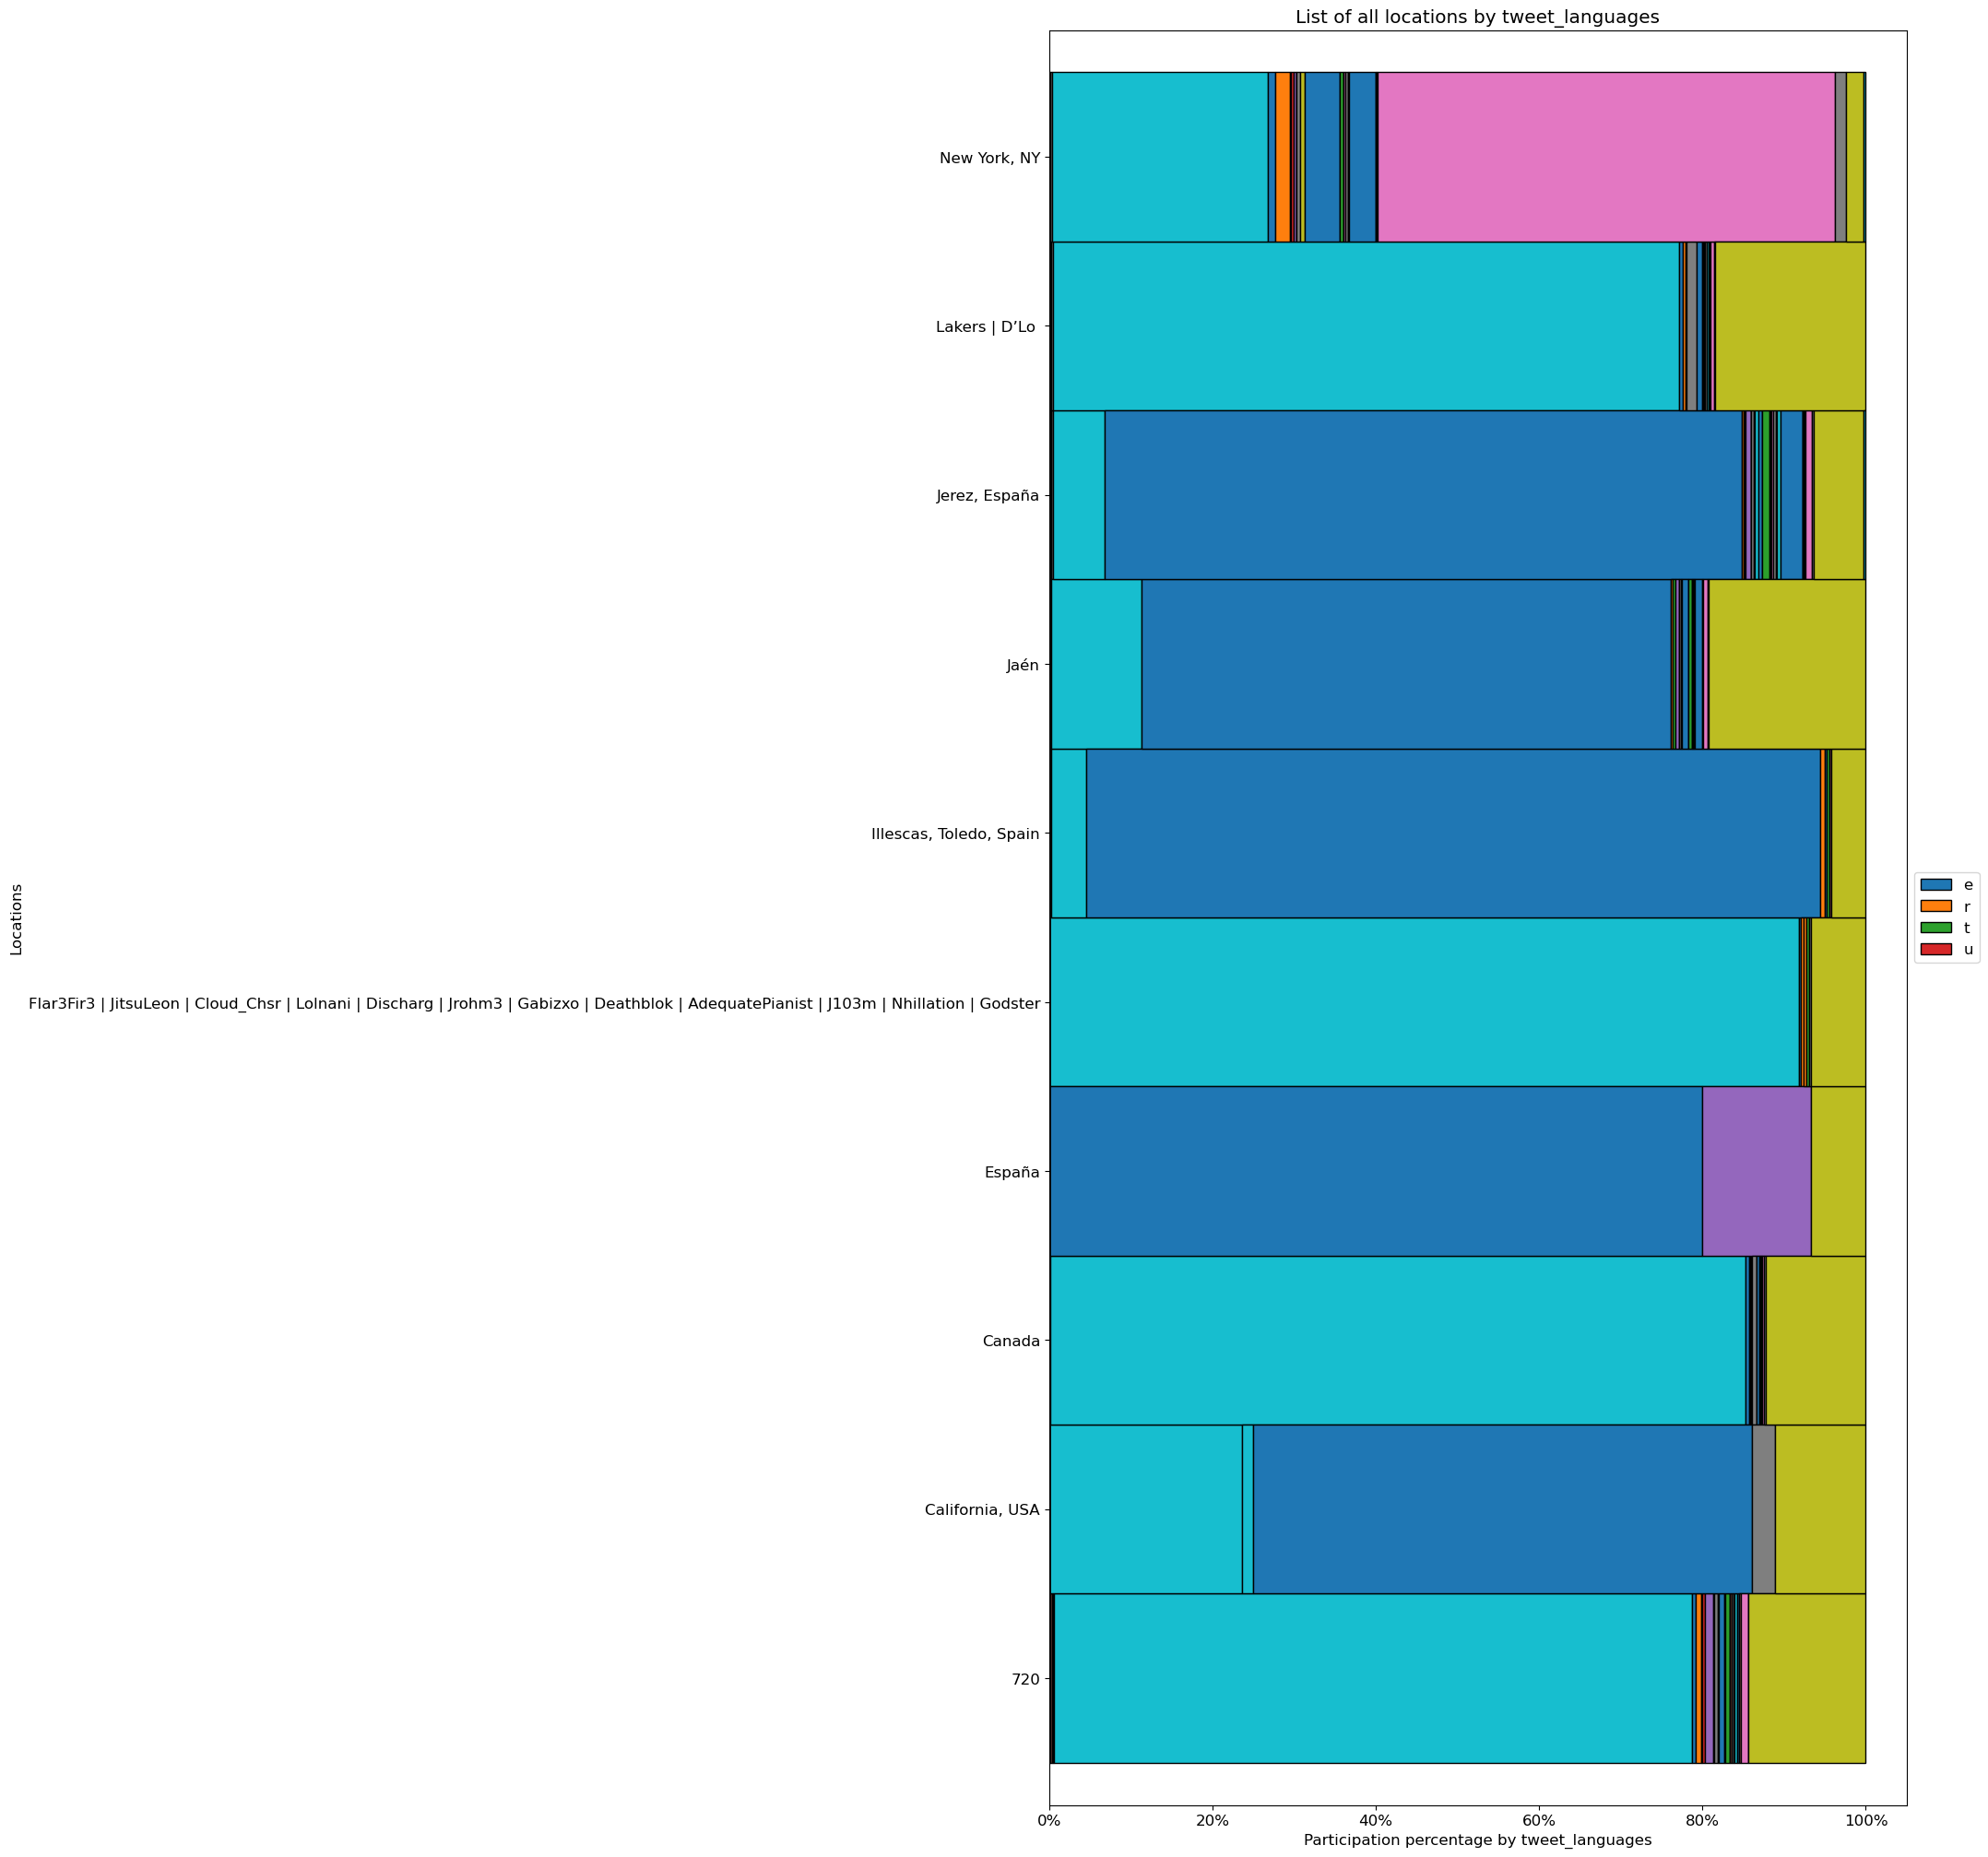

In [115]:
location_by_tweet_language_count_df = df.groupBy(df.user_reported_location, df.tweet_language).count().toPandas()

tweet_languages = location_by_tweet_language_count_df['tweet_language'].unique()

fig = plt.figure(figsize=(12, 25))
grid_size = (1,1);
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
plot = location_by_tweet_language_count_df.groupby(['user_reported_location', 'tweet_language'],group_keys=True).agg(np.mean) \
    .groupby(level=0,group_keys=False) \
    .apply(
        lambda x: 100 * x / x.sum()).unstack().plot(kind='barh', 
                                                    stacked=True, 
                                                    width=1,
                                                    edgecolor='black', 
                                                    ax=ax, 
                                                    title='List of all locations by tweet_languages')
ylabel = plt.ylabel('Locations');
xlabel = plt.xlabel('Participation percentage by tweet_languages');
legend = plt.legend(
    sorted(is_retweet), loc='center left', bbox_to_anchor=(1.0, 0.5)
)
param_update = plt.rcParams.update({'font.size': 16});
ax = plt.gca()
formatter = ax.xaxis.set_major_formatter(mtick.PercentFormatter());
a = fig.tight_layout()
plt.show()

In [ ]:
Переработаем график:

<Axes: xlabel='user_reported_location'>

Text(0.5, 1.0, 'List of all locations by tweet languages')

Text(0, 0.5, 'Locations')

Text(0.5, 0, 'Participation percentage by tweet languages')

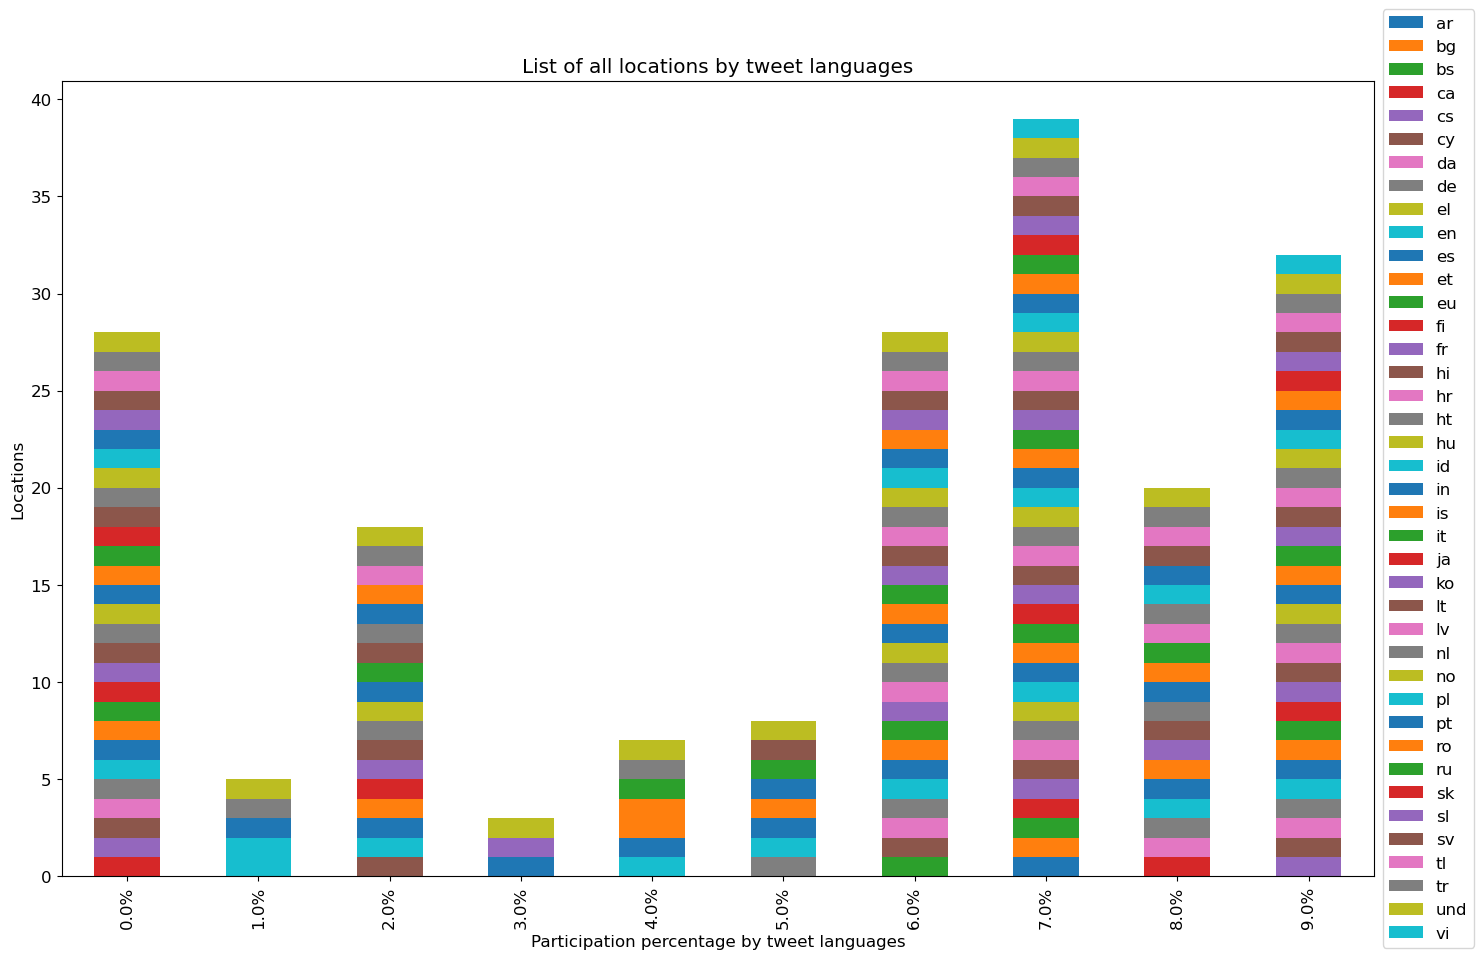

In [117]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

location_by_tweet_language_count_df.groupby(['user_reported_location', 'tweet_language']).size().unstack().plot(kind='bar', stacked=True, ax=ax)

plt.title('List of all locations by tweet languages')
plt.ylabel('Locations')
plt.xlabel('Participation percentage by tweet languages')

# Изменяем положение легенды, чтобы она была вне графика
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Включаем форматтер процентов для оси X
ax.xaxis.set_major_formatter(mtick.PercentFormatter())

# Устанавливаем размер шрифта
plt.rcParams.update({'font.size': 12})

plt.tight_layout()
plt.show()


Процентное соотношение языков твитов и местоположений пользователей

In [25]:
user_reported_location_by_tweet_language_df = df.groupBy(df.user_reported_location, df.tweet_language).count().toPandas().pivot_table(
    index="user_reported_location", columns="tweet_language", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1)

user_reported_location_by_tweet_language_df['all'] = 0
for tweet_language in tweet_languages:
    user_reported_location_by_tweet_language_df['all'] += user_reported_location_by_tweet_language_df[tweet_language]
    
user_reported_location_by_tweet_language_df['percent'] = user_reported_location_by_tweet_language_df['all'] / np.sum(user_reported_location_by_tweet_language_df['all']) * 100

for tweet_language in tweet_languages:
    user_reported_location_by_tweet_language_df['percent ' + tweet_language] = \
        (user_reported_location_by_tweet_language_df[tweet_language] / user_reported_location_by_tweet_language_df['all']) * 100

user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.sort_values(
    by='percent', ascending=False
).head(10)

others = {'tweet_language': 'others'}
for column in [*['all', 'percent'], *tweet_languages]:
    value = np.sum(user_reported_location_by_tweet_language_df[column]) - np.sum(user_reported_location_by_tweet_language_df[column])
    others.update({column: value})

for tweet_language in tweet_languages:
    value = (others[tweet_language] / others['all']) * 100
    others.update({'percent ' + str(tweet_language): value})  # Исправлено использование str() для ключа

user_reported_location_by_tweet_language_df = pd.concat([user_reported_location_by_tweet_language_df, pd.DataFrame.from_dict([others])]) \
    .reset_index(drop=True)

# Удаление последней колонки "is_retweet"
user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.drop("tweet_language", axis=1)

# Удаление последней строки "nan"
user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.dropna()

user_reported_location_by_tweet_language_df


/tmp/ipykernel_106/3514135481.py:26: RuntimeWarning: invalid value encountered in scalar divide
  value = (others[tweet_language] / others['all']) * 100


user_reported_location  ar  bg  bs  ca  cs  cy  \
0                                      Jerez, España   1   1   3  10   9  18   
1                                       New York, NY   0   0   0   0   5  27   
2                                               Jaén   0   0   1   0   0   2   
3                                                720   0   0   0   2   1   4   
4                                     Lakers | D’Lo    0   0   0   2   0   0   
5                                             Canada   0   0   0   0   0   3   
6                            Illescas, Toledo, Spain   0   0   0   0   0   0   
7  Flar3Fir3 | JitsuLeon | Cloud_Chsr | Lolnani |...   0   0   0   0   0   0   
8                                    California, USA   0   0   0   0   0   0   
9                                             España   0   0   0   0   0   0   

   da  de  el  ...  percent bs  percent it  percent lt  percent id  \
0  40  74   1  ...    0.008449    0.909705    0.160536    0.475976   
1   6  44   0  ...    0.000000    0.347191    0.044512    0.000000   
2   2   3   0  ...    0.026116    0.391747    0.052233    0.000000   
3   3   4   0  ...    0.000000    0.494827    0.179937    0.000000   
4   2   6   0  ...    0.000000    0.148075    0.000000    0.000000   
5   0   0   0  ...    0.000000    0.054377    0.054377    0.000000   
6   0   1   0  ...    0.000000    0.263852    0.000000    0.000000   
7   0   0   0  ...    0.000000    0.303951    0.000000    0.000000   
8   0   0   0  ...    0.000000    0.000000    0.000000    0.000000   
9   0   0   0  ...    0.000000    0.000000    0.000000    0.000000   

   percent el  percent ru  percent ar  percent ja  percent bg  percent ko  
0    0.002816    0.005633    0.002816    0.000000    0.002816    0.002816  
1    0.000000    0.000000    0.000000    0.000000    0.000000    0.013354  
2    0.000000    0.000000    0.000000    0.000000    0.000000    0.026116  
3    0.000000    0.000000    0.000000    0.089969    0.000000    0.000000  
4    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
5    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
6    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
7    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
8    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  
9    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000  

[10 rows x 83 columns]

Возьмем такие языки: en(Англия), de(Германия), es(Испания), in(Индия):	

In [120]:
tweet_languagess = ['en', 'de', 'es', 'in']  # измененное имя списка

user_reported_location_by_tweet_language_df = df.groupBy(df.user_reported_location, df.tweet_language).count().toPandas().pivot_table(
    index="user_reported_location", columns="tweet_language", values='count', fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1)

user_reported_location_by_tweet_language_df['all'] = 0
for tweet_language in tweet_languagess:
    user_reported_location_by_tweet_language_df['all'] += user_reported_location_by_tweet_language_df[tweet_language]
    
user_reported_location_by_tweet_language_df['percent'] = user_reported_location_by_tweet_language_df['all'] / np.sum(user_reported_location_by_tweet_language_df['all']) * 100

for tweet_language in tweet_languagess:
    user_reported_location_by_tweet_language_df['percent ' + tweet_language] = \
        (user_reported_location_by_tweet_language_df[tweet_language] / user_reported_location_by_tweet_language_df['all']) * 100

user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.sort_values(
    by='percent', ascending=False
).head(10)

others = {'tweet_language': 'others'}
for column in [*['all', 'percent'], *tweet_languagess]:
    value = np.sum(user_reported_location_by_tweet_language_df[column]) - np.sum(user_reported_location_by_tweet_language_df[column])
    others.update({column: value})

for tweet_language in tweet_languagess:
    value = (others[tweet_language] / others['all']) * 100
    others.update({'percent ' + str(tweet_language): value})  # Исправлено использование str() для ключа

user_reported_location_by_tweet_language_df = pd.concat([user_reported_location_by_tweet_language_df, pd.DataFrame.from_dict([others])]) \
    .reset_index(drop=True)

# Удаление последней колонки "tweet_language"
user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.drop("tweet_language", axis=1)

# Удаление последней строки "nan"
user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df.dropna()

columns_to_keep = ['user_reported_location', 'percent', 'percent en', 'percent de', 'percent es', 'percent in']
user_reported_location_by_tweet_language_df = user_reported_location_by_tweet_language_df[columns_to_keep]

user_reported_location_by_tweet_language_df


/tmp/ipykernel_106/3977509495.py:28: RuntimeWarning: invalid value encountered in scalar divide
  value = (others[tweet_language] / others['all']) * 100


user_reported_location    percent  percent en  \
0                                      Jerez, España  65.748083    7.544482   
1                                       New York, NY  15.606483   82.872697   
2                                               Jaén   6.400314   14.533696   
3                                                720   3.847159   98.357871   
4                                     Lakers | D’Lo    3.450680   97.979798   
5                                             Canada   3.441966   99.113924   
6                            Illescas, Toledo, Spain   0.782067    4.456825   
7  Flar3Fir3 | JitsuLeon | Cloud_Chsr | Lolnani |...   0.660073   99.669967   
8                                    California, USA   0.037034  100.000000   
9                                             España   0.026142    0.000000   

   percent de  percent es  percent in  
0    0.245187   91.690136    0.520195  
1    0.614182    2.805695   13.707426  
2    0.102110   84.343091    1.021103  
3    0.226501    0.453001    0.962627  
4    0.378788    0.694444    0.946970  
5    0.000000    0.443038    0.443038  
6    0.278552   94.986072    0.278552  
7    0.000000    0.330033    0.000000  
8    0.000000    0.000000    0.000000  
9    0.000000  100.000000    0.000000

Распределение количества подписчиков на всех пользователей отфильтрованного фрейма:

array([[<Axes: title={'center': 'follower_count'}>]], dtype=object)

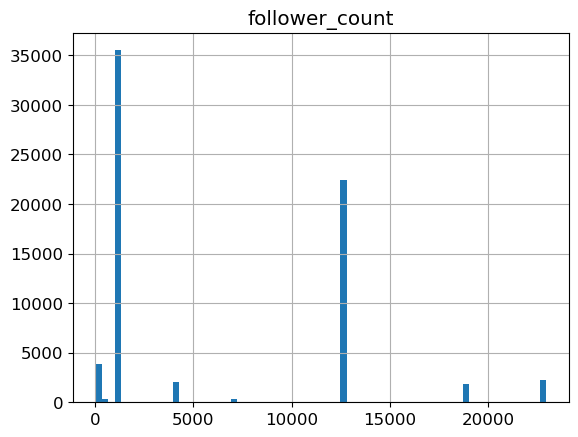

In [121]:
df.select(df.follower_count, df.userid).toPandas().hist(column='follower_count',bins=70)

Среднее количество подписчиков в зависимости от местоположения пользователя:

<Axes: xlabel='user_reported_location'>

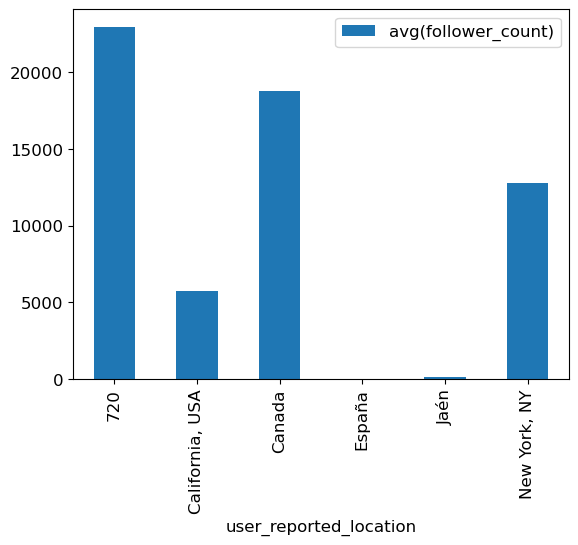

In [122]:
is_user_reported_location = ['Jerez', 'España', 'New York, NY', 'Jaén', '720', 'Lakers | D’Lo', 'Canada', 'Illescas', 'Toledo', 'Spain','California, USA']

df.select(df.user_reported_location, df.follower_count) \
    .filter(df.user_reported_location.isin(is_user_reported_location)) \
    .groupBy(df.user_reported_location) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='user_reported_location') \
    .plot.bar(column="avg(follower_count)", x='user_reported_location', rot=90)

Среднее число подписчиков на каждую страну проживания пользователя:

<Axes: ylabel='tweet_language'>

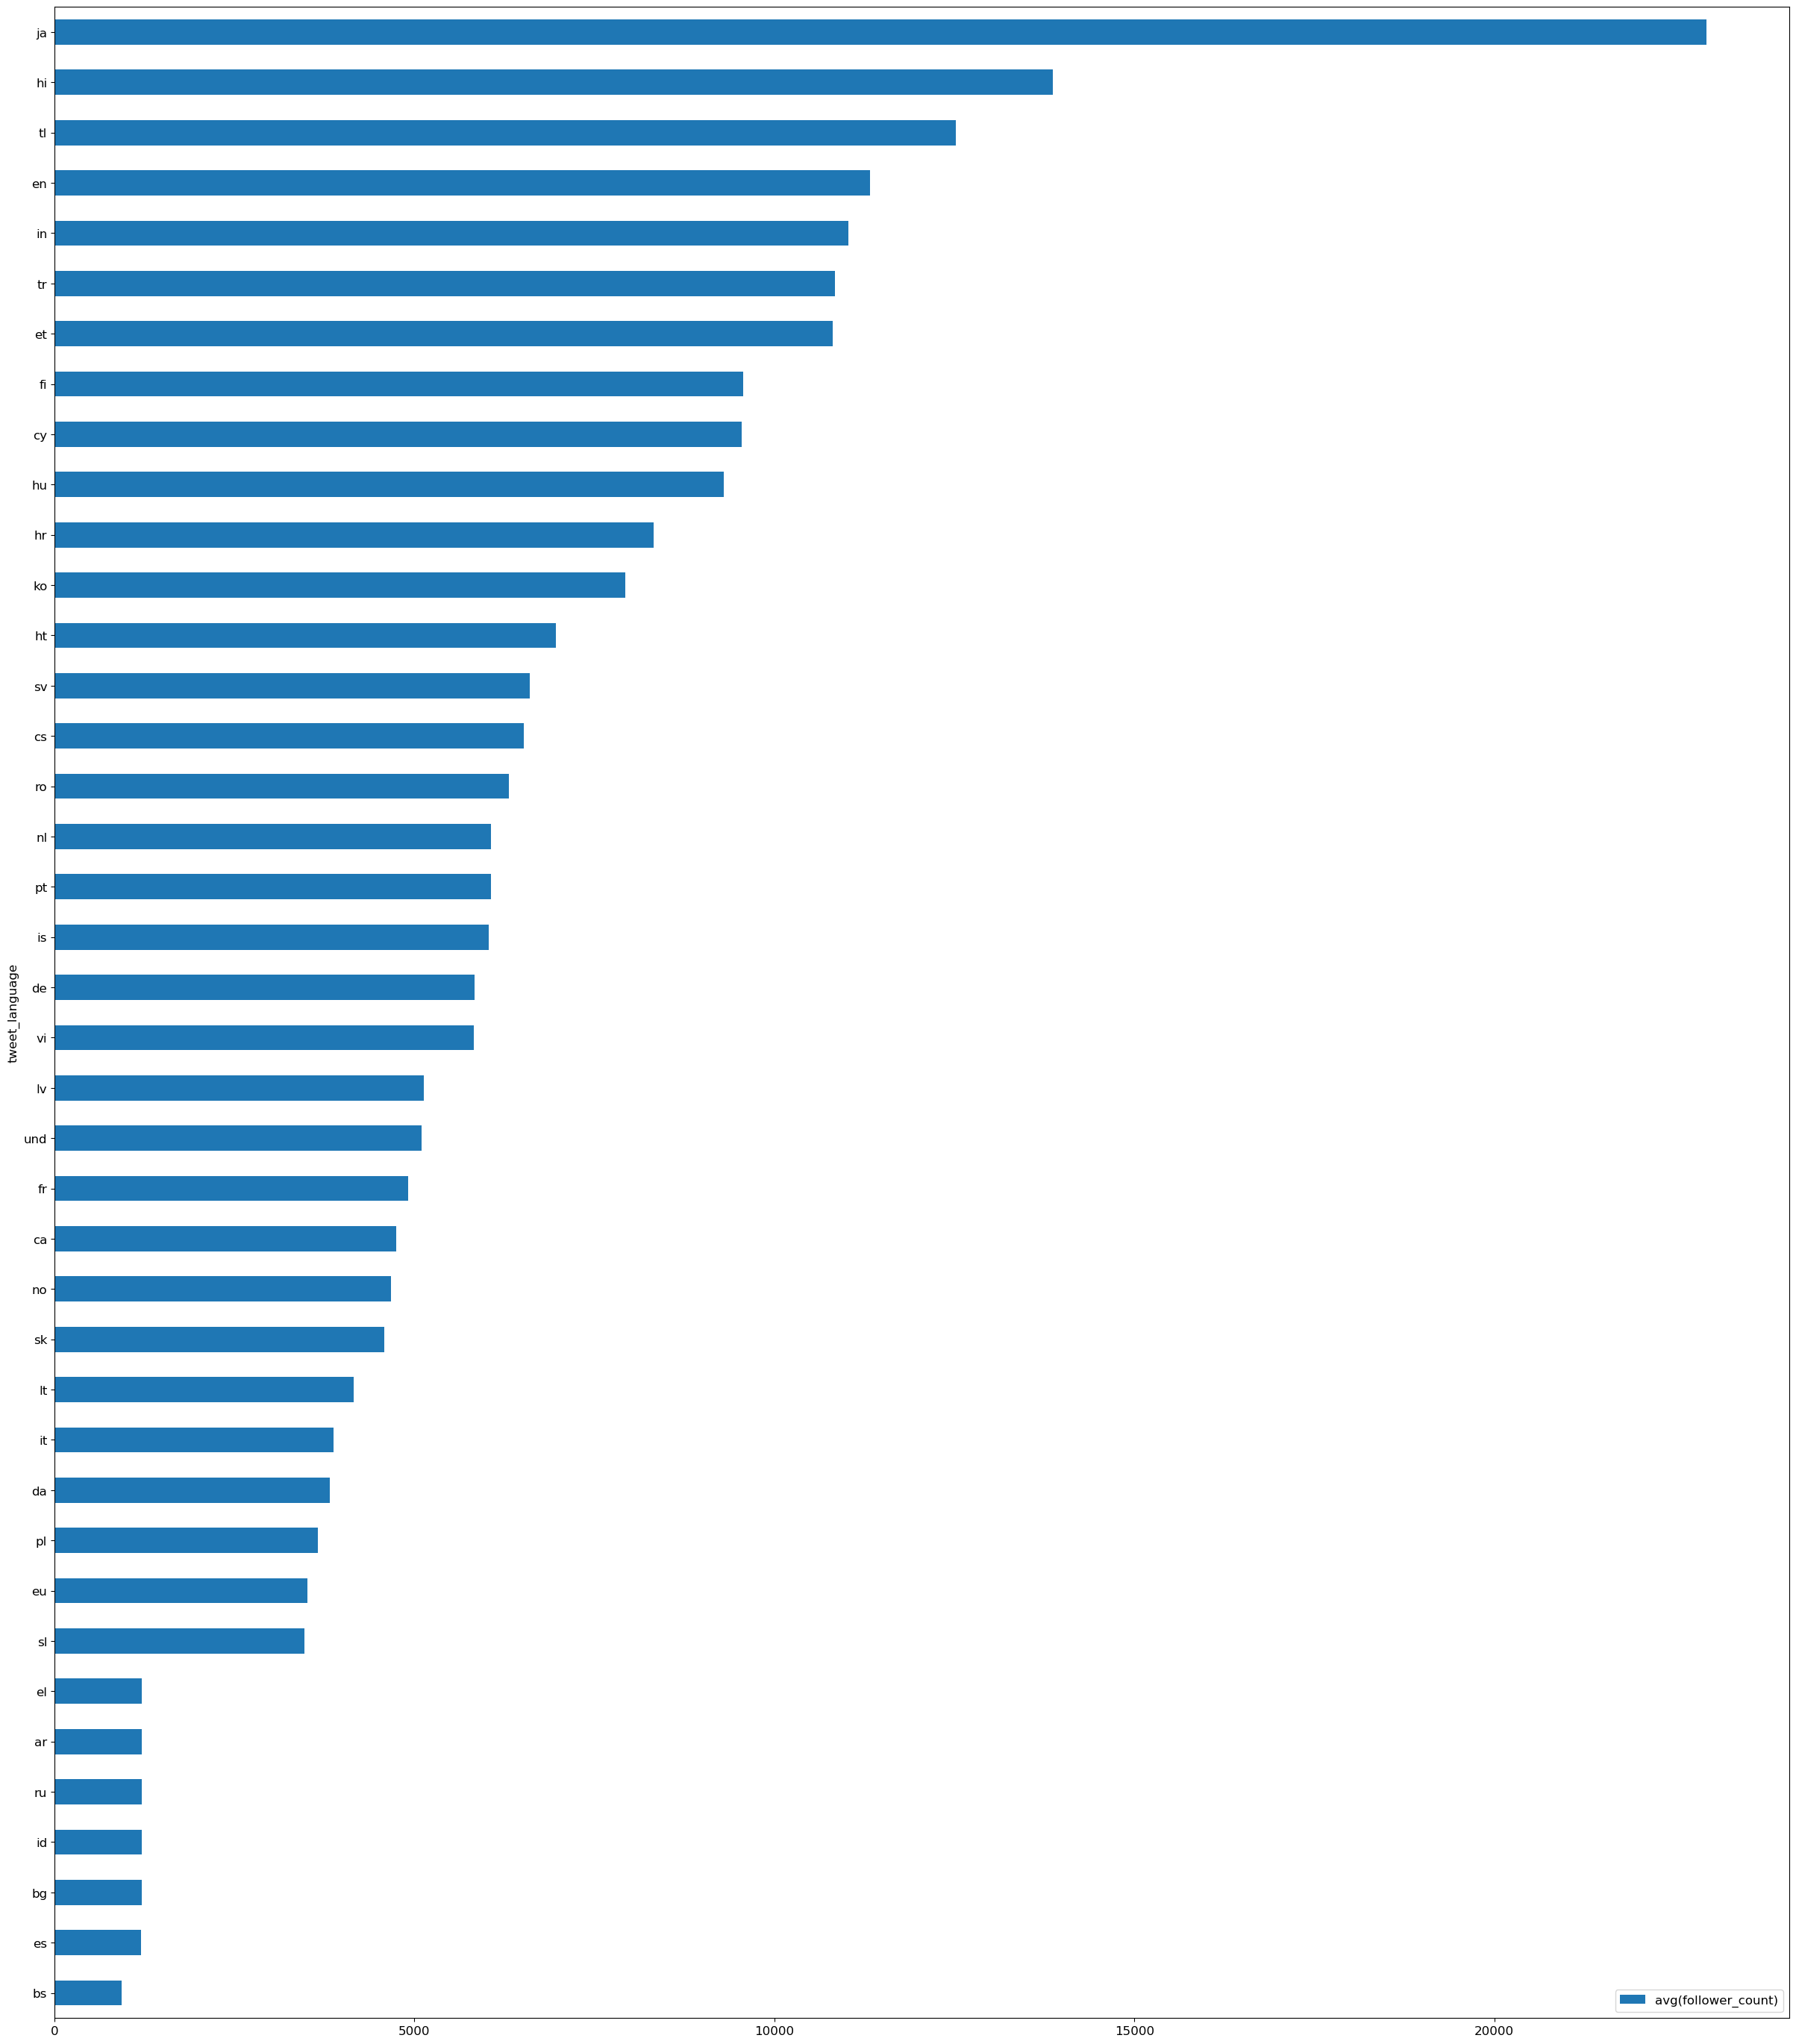

In [123]:
df.select(df.tweet_language, df.follower_count) \
    .groupBy(df.tweet_language) \
    .avg('follower_count') \
    .toPandas() \
    .sort_values(by='avg(follower_count)') \
    .plot.barh(column="avg(follower_count)", x='tweet_language', figsize=(30,35))

Списки и количество пользователей с конкретной страны, зарегестированные в определенную дату


Lists and the number of users from a specific country registered on a specific date:


/tmp/ipykernel_106/4004656197.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  PerWorkoutRecordCount_dist = df.select('tweet_language', 'account_creation_date').toPandas().hist(


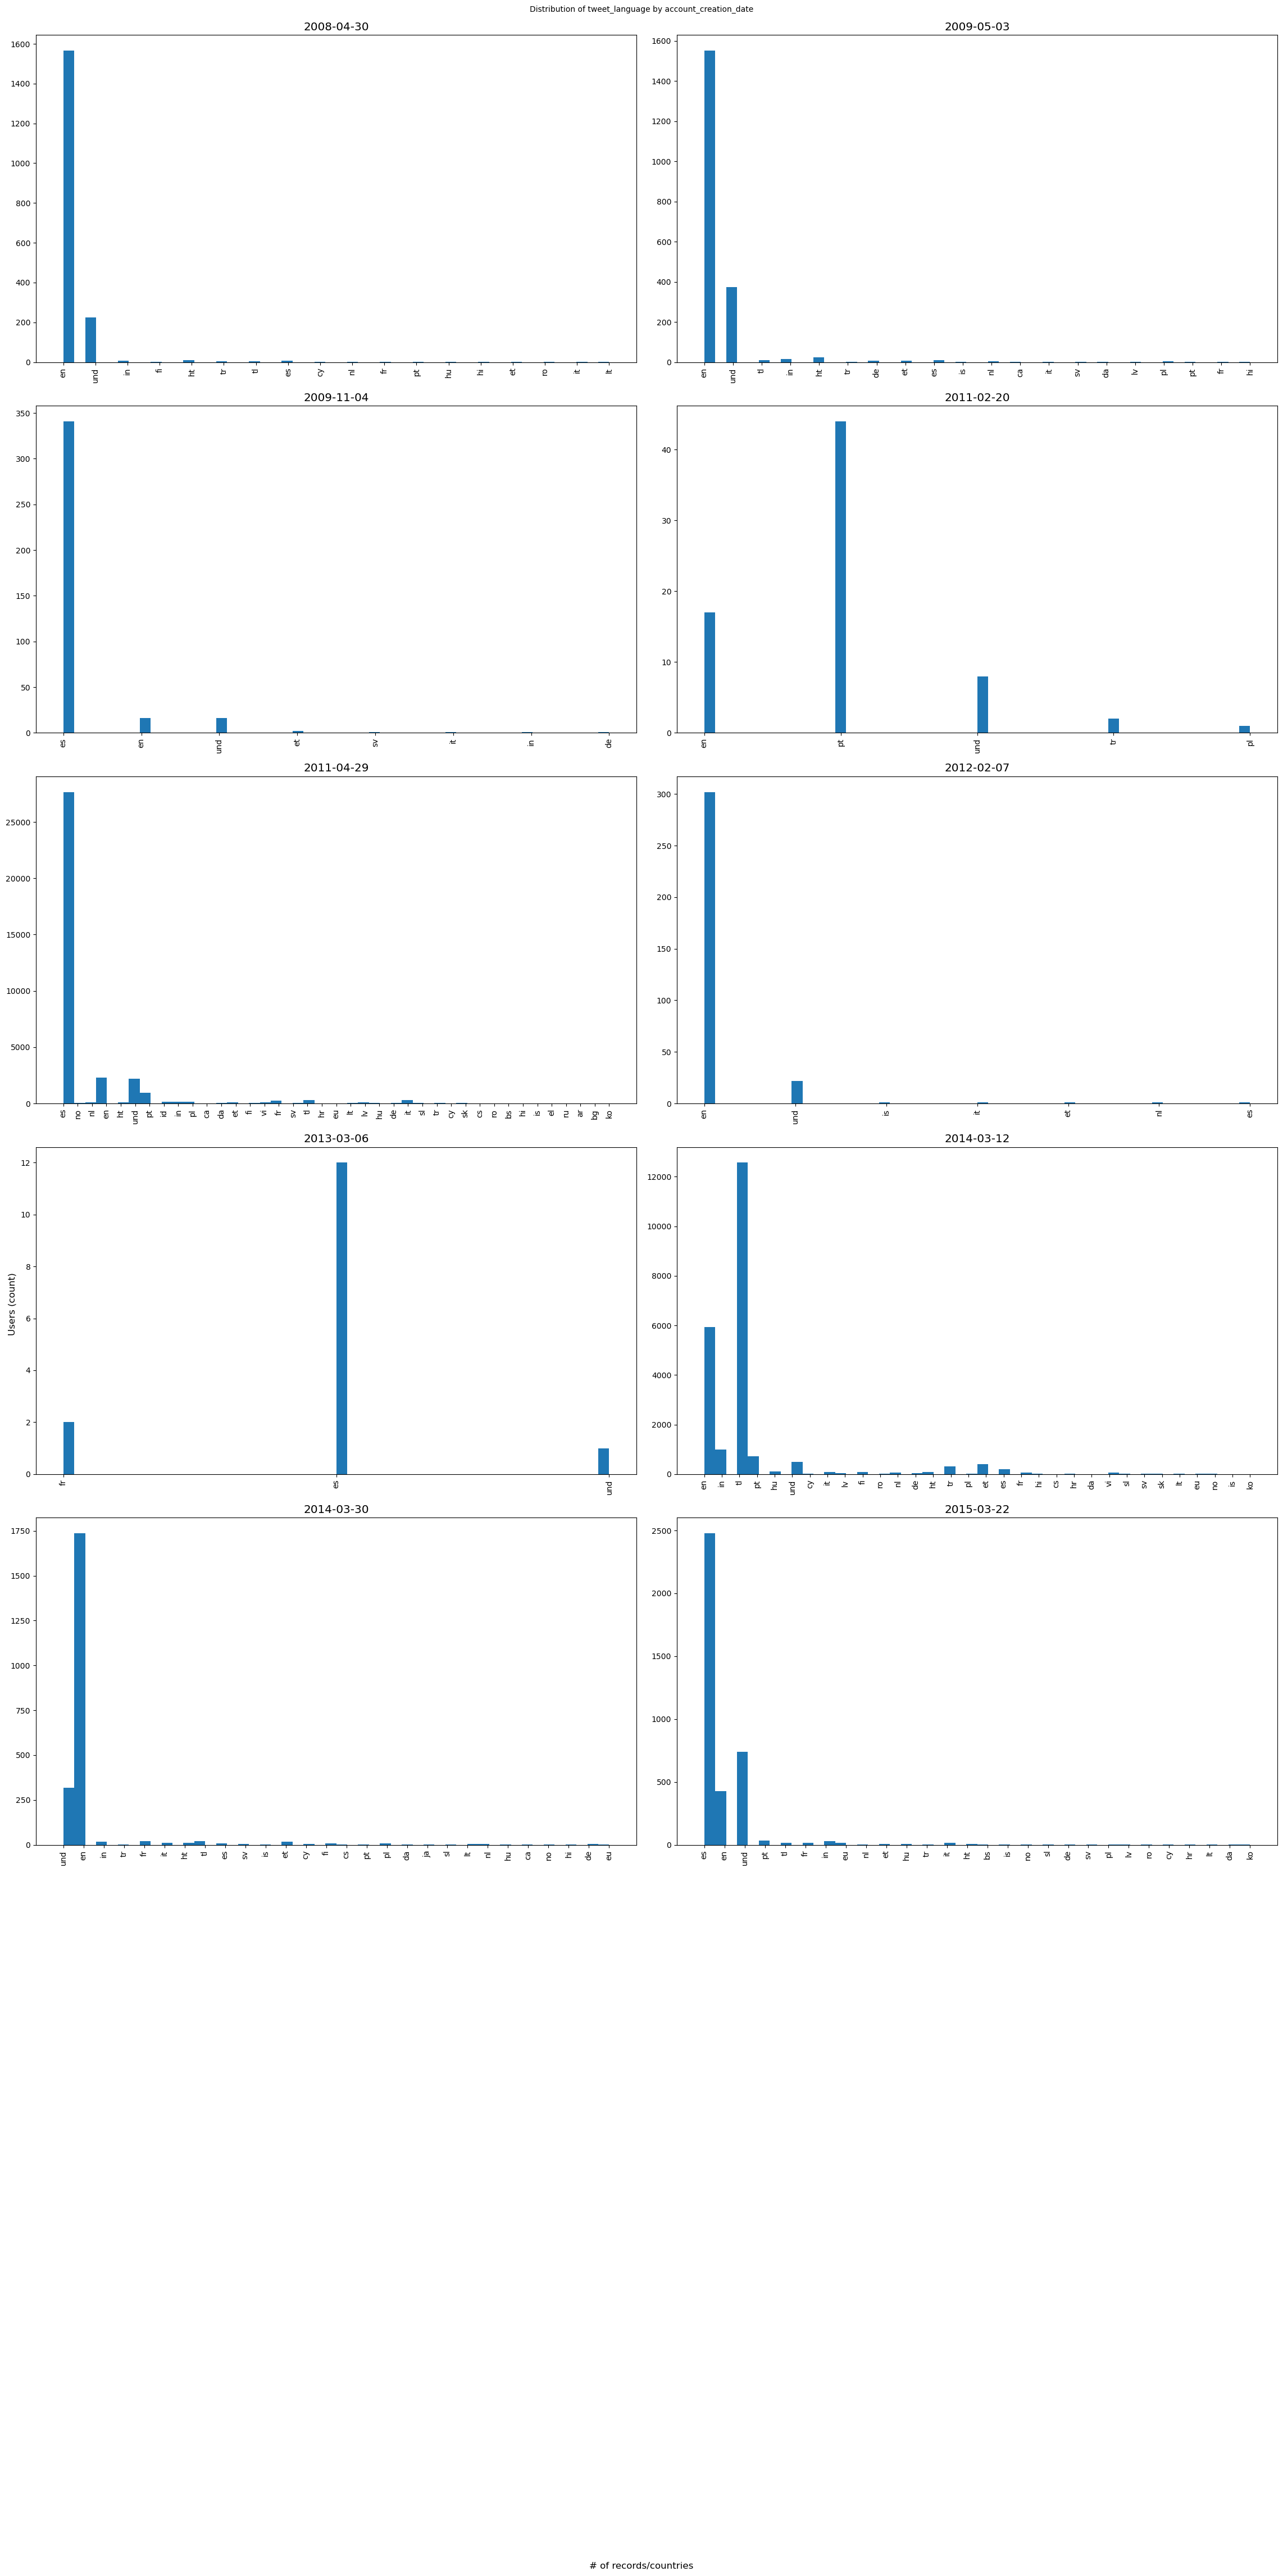

In [128]:
print('\nLists and the number of users from a specific country registered on a specific date:')
plot_size_x, plot_size_y = 5, 5
figsize_x, figsize_y = plot_size_x * 4 + 3, plot_size_y * 9 + 1
figsize=(figsize_x, figsize_y)
fig = plt.figure(figsize=figsize) #
grid_size = (7,2)
ax = plt.subplot2grid(grid_size, (0,0), colspan=1, rowspan=1)
#fig, ax = plt.subplots()
PerWorkoutRecordCount_dist = df.select('tweet_language', 'account_creation_date').toPandas().hist(
    column='tweet_language', bins=50, sharex = False, grid=True
    , xlabelsize='small', ylabelsize='small', by='account_creation_date', ax = ax
    , layout = grid_size, figsize=figsize
    )
a = fig.tight_layout()
title = fig.text(0.5, 1, 'Distribution of tweet_language by account_creation_date', ha='center' 
         , fontsize='small', transform=fig.transFigure);
xlabel = fig.text(
    0.5, 0.01, '# of records/countries', va='bottom', ha='center', transform=fig.transFigure
)
ylabel = fig.text(0.01, 0.5, 'Users (count)', va='center', rotation='vertical');

Среднее количество подписчиков в зависимости от местоположения пользователей:

In [129]:
highest_user_reported_location_follower_count_mean = []
highest_user_reported_location_follower_count_stddev = []
highest_user_reported_location_follower_count_min = []
highest_user_reported_location_follower_count_max = []

for user_reported_location in highest_twitter_df['user_reported_location']:
    if user_reported_location != 'others': 
        describe_values = df.select(df.follower_count).filter(df.user_reported_location == user_reported_location).describe().toPandas()
    else:
        user_reported_location = highest_twitter_df['user_reported_location'].tolist()
        describe_values = df.select(df.follower_count).filter(col('user_reported_location').isin(user_reported_location) == False).describe().toPandas()
    highest_user_reported_location_follower_count_mean.append(float(describe_values.loc[1]['follower_count']))
    highest_user_reported_location_follower_count_stddev.append(float(describe_values.loc[2]['follower_count']))
    highest_user_reported_location_follower_count_min.append(float(describe_values.loc[3]['follower_count']))
    highest_user_reported_location_follower_count_max.append(float(describe_values.loc[4]['follower_count']))

highest_twitter_df['mean follower_count'] = highest_user_reported_location_follower_count_mean
highest_twitter_df['stddev follower_count'] = highest_user_reported_location_follower_count_stddev
highest_twitter_df['min follower_count'] = highest_user_reported_location_follower_count_min
highest_twitter_df['max follower_count'] = highest_user_reported_location_follower_count_max
    
highest_twitter_df

user_reported_location  count  percentage  mean follower_count  \
0          Jerez, España  35506   51.694718          1210.000000   
1           New York, NY  22466   32.709219         12781.000000   
2                   Jaén   3829    5.574806           108.000000   
3                    720   2223    3.236562         22948.000000   
4         Lakers | D’Lo    2026    2.949741          4209.000000   
0                 others   2634    3.834954         14193.936219   

   stddev follower_count  min follower_count  max follower_count  
0               0.000000              1210.0              1210.0  
1               0.000000             12781.0             12781.0  
2               0.000000               108.0               108.0  
3               0.000000             22948.0             22948.0  
4               0.000000              4209.0              4209.0  
0            7163.875362                14.0             18765.0

Диаграмма "ящик с усами" по всем странам датафрейма с количеством фолловеров

/tmp/ipykernel_106/791942736.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  boxplot_rows = math.ceil(all_tweet_languages.count()/boxplot_cols)


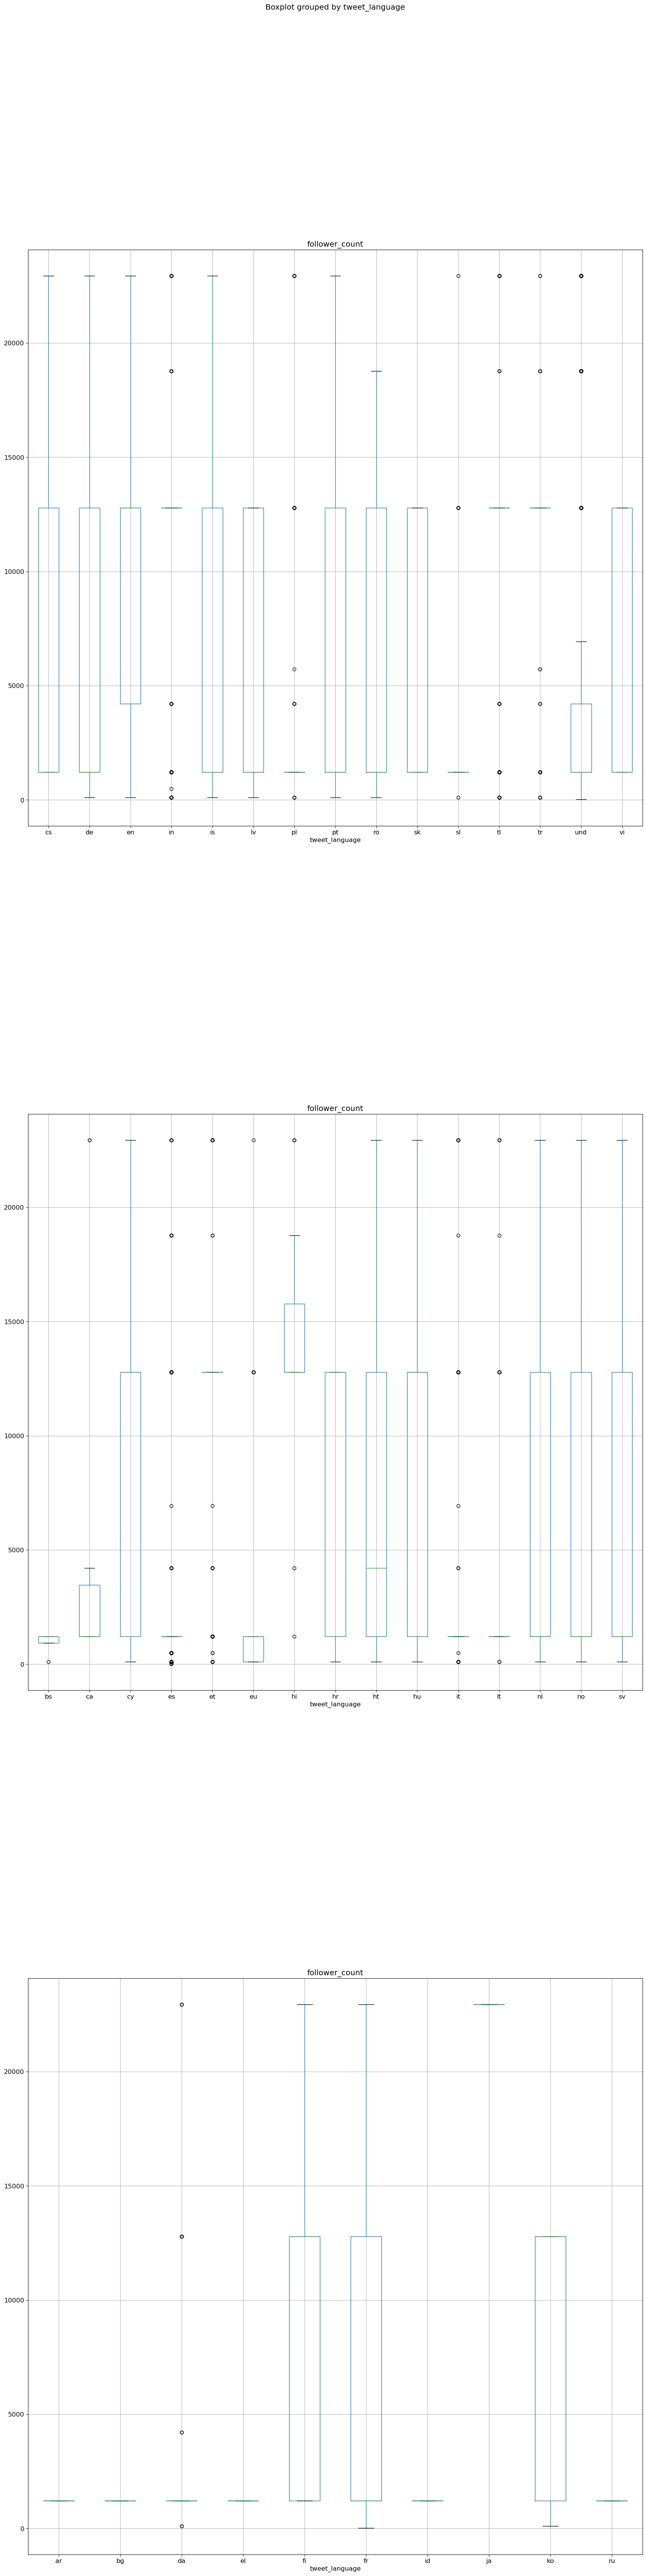

In [130]:
all_tweet_languages = df.select(df.tweet_language).distinct().toPandas()
boxplot_cols = 15
boxplot_rows = math.ceil(all_tweet_languages.count()/boxplot_cols)

fig, axes = plt.subplots(boxplot_rows, figsize=(20, 80))

for row in range(0,boxplot_rows):
    current_tweet_languages = all_tweet_languages.iloc[row*boxplot_cols:row*boxplot_cols+boxplot_cols]['tweet_language'].values.tolist()
    follower_count_df = df.select(df.tweet_language, df.follower_count).filter(col('tweet_language').isin(current_tweet_languages)).toPandas()
    follower_count_df['follower_count'] = follower_count_df['follower_count'].astype('double')
    follower_count_df.boxplot(column='follower_count', by='tweet_language', ax=axes[row])
    
plt.subplots_adjust(hspace=0.5)
plt.show();

Узнаем, какие страны имеют самое большое количество фолловеров, и отобразим топ 10 этих стран с местоположением

In [131]:
all_tweet_languages = df.select(df.tweet_language) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

most_popular_languages = []

for tweet_language in all_tweet_languages:
    most_popular_language_df = df.select(df.user_reported_location) \
        .filter(df.tweet_language == tweet_language) \
        .groupBy(df.user_reported_location) \
        .count() \
        .orderBy('count', ascending=False) \
        .head(1)
    
    if most_popular_language_df:
        most_popular_language = most_popular_language_df[0]
        most_popular_languages.append({
            'tweet_language': tweet_language,
            'user_reported_location': most_popular_language.user_reported_location,
            'count': most_popular_language['count']
        })

top_most_popular_languages_df = pd.DataFrame(most_popular_languages)

if not top_most_popular_languages_df.empty:
    top_most_popular_languages_df = top_most_popular_languages_df.sort_values(by='count', ascending=False).head(10).reset_index(drop=True)
    
top_most_popular_languages_df


tweet_language user_reported_location  count
0             es          Jerez, España  27673
1             tl           New York, NY  12568
2             en           New York, NY   5937
3            und          Jerez, España   2183
4             in           New York, NY    982
5             pt          Jerez, España    956
6             et           New York, NY    413
7             it          Jerez, España    323
8             tr           New York, NY    311
9             fr          Jerez, España    238

Соотношение подписчики-подписки пользователей по 10 самым популярным странам

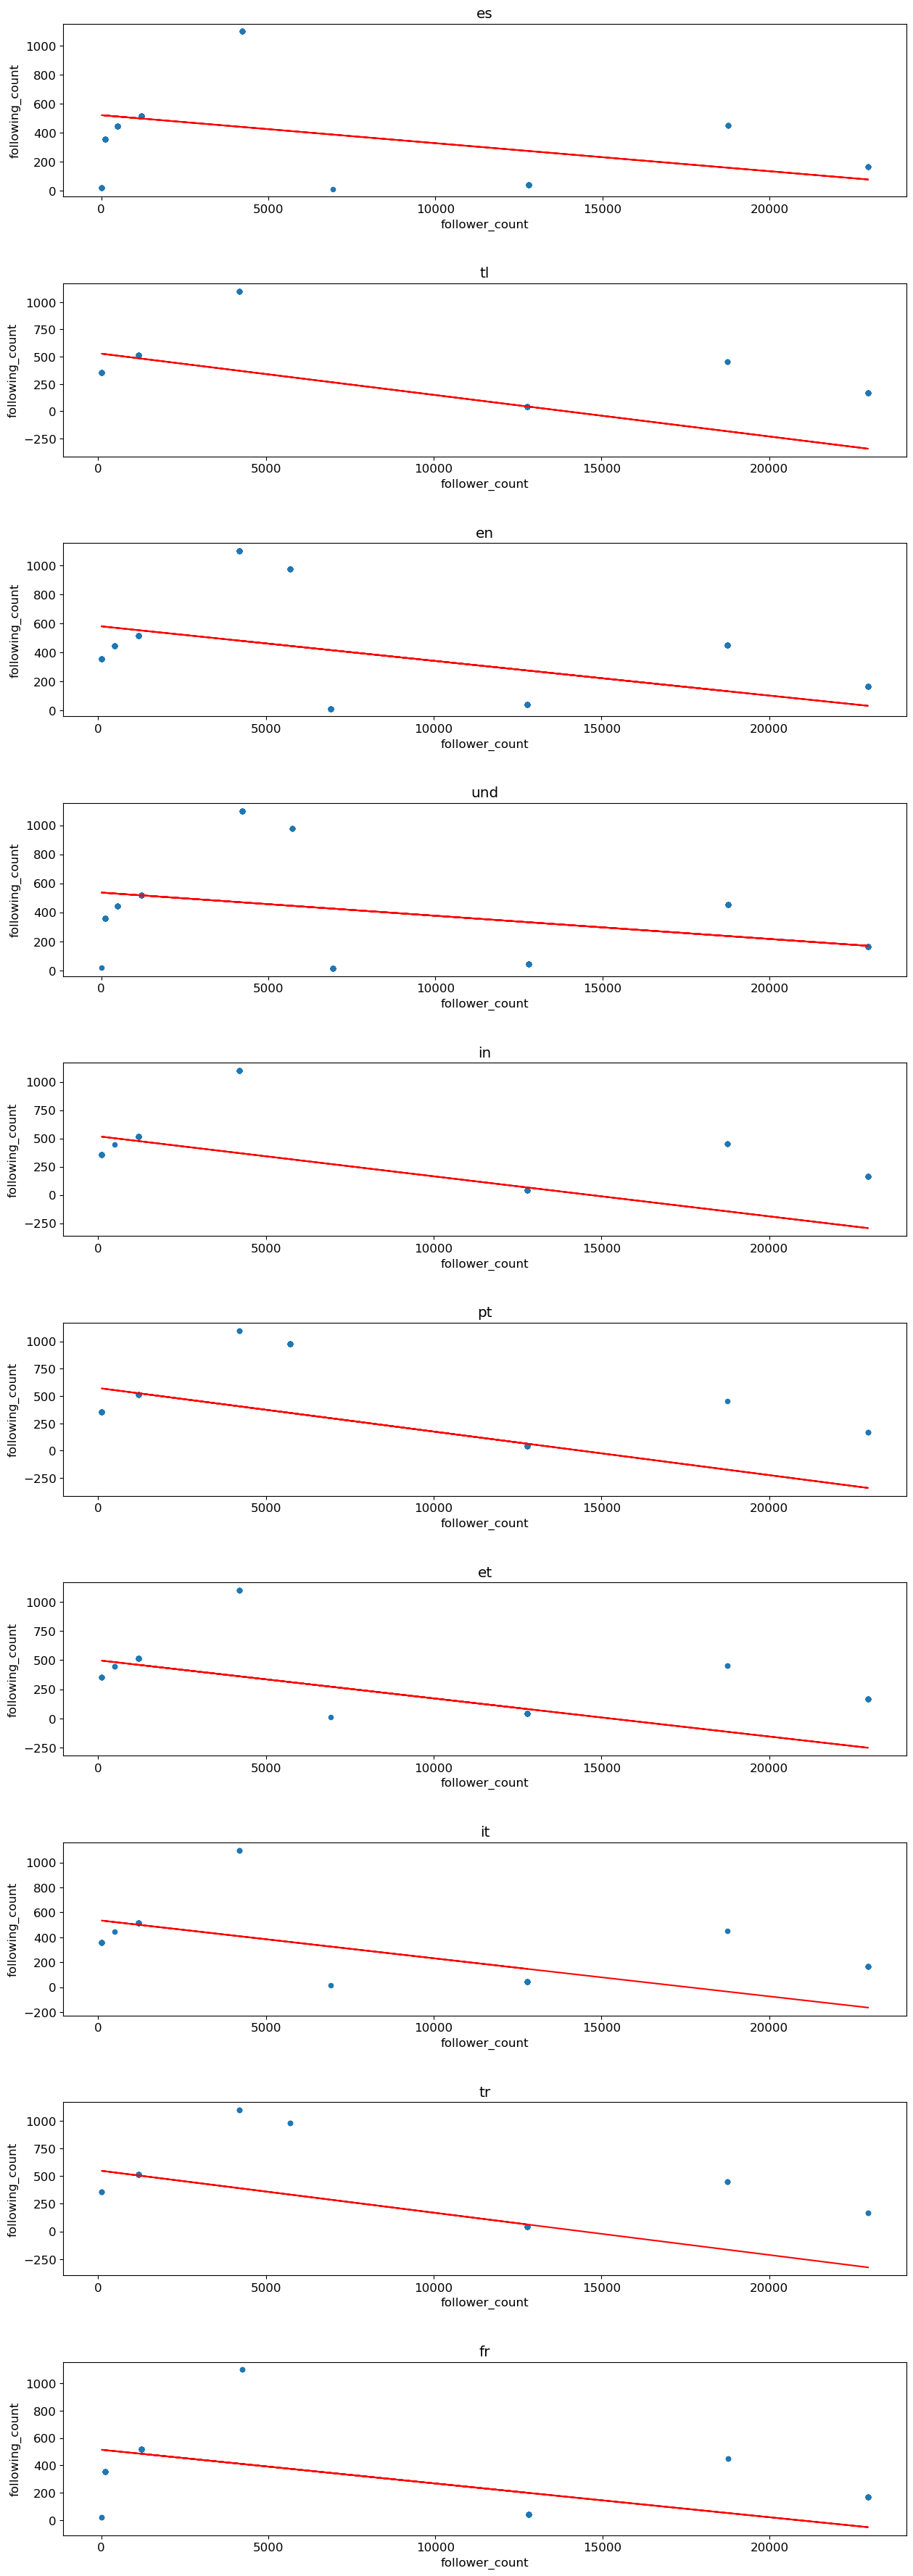

In [132]:
fig, axs = plt.subplots(nrows=10, figsize=(15,45))
fig.subplots_adjust(hspace=0.5)  # устаналиваем вертикальное расстояние между графиками в пять раз больше, чем по умолчанию

for i in range(10):
    sub_df = df.select(df.following_count, df.follower_count) \
                .filter((df.tweet_language == top_most_popular_languages_df.iloc[i]['tweet_language'])) \
                .toPandas()
    
    q = sub_df.plot.scatter(x='follower_count', y='following_count', ax=axs[i])
    a, b = np.polyfit(sub_df['follower_count'], sub_df['following_count'], 1)
    w = axs[i].plot(sub_df['follower_count'], a*sub_df['follower_count']+b, color='Red')
    e = axs[i].set_title(top_most_popular_languages_df.iloc[i]['tweet_language'])

Статистика фолловеров для каждого местоположения

In [133]:
from pyspark.sql.functions import percentile_approx, min, max, mean, stddev

language_followers_statistic_df = []

for tweet_language in all_tweet_languages:
    stat_dict = {'tweet_language': tweet_language}
    language_followers_df = df.select(df.follower_count).filter(df.tweet_language==tweet_language)
    stats = language_followers_df.select(
        percentile_approx(df.follower_count,[0.25,0.5,0.75,0.95], 1000000).alias("percentiles"),
        min(df.follower_count).alias('min'),
        max(df.follower_count).alias('max'),
        mean(df.follower_count).alias('mean'),
        stddev(df.follower_count).alias('stddev'),
    ).collect()[0]
    
    stat_dict['25th percentile'] = stats['percentiles'][0] 
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']
    
    language_followers_statistic_df.append(stat_dict)
    
language_followers_statistic_df = pd.DataFrame(language_followers_statistic_df)
language_followers_statistic_df


tweet_language  25th percentile  50th percentile  75th percentile  \
0              en           4209.0          12781.0          12781.0   
1              vi           1210.0           1210.0          12781.0   
2              ro           1210.0           1210.0          12781.0   
3              sl           1210.0           1210.0           1210.0   
4             und           1210.0           1210.0           4209.0   
5              lv           1210.0           1210.0          12781.0   
6              pl           1210.0           1210.0           1210.0   
7              sk           1210.0           1210.0          12781.0   
8              pt           1210.0           1210.0          12781.0   
9              tl          12781.0          12781.0          12781.0   
10             in          12781.0          12781.0          12781.0   
11             cs           1210.0           1210.0          12781.0   
12             tr          12781.0          12781.0          12781.0   
13             de           1210.0           1210.0          12781.0   
14             is           1210.0           1210.0          12781.0   
15             es           1210.0           1210.0           1210.0   
16             hr           1210.0          12781.0          12781.0   
17             eu            108.0           1210.0           1210.0   
18             it           1210.0           1210.0           1210.0   
19             sv           1210.0           1210.0          12781.0   
20             nl           1210.0           1210.0          12781.0   
21             hu           1210.0          12781.0          12781.0   
22             ca           1210.0           1210.0           4209.0   
23             lt           1210.0           1210.0           1210.0   
24             ht           1210.0           4209.0          12781.0   
25             no           1210.0           1210.0          12781.0   
26             cy           1210.0          12781.0          12781.0   
27             hi          12781.0          12781.0          18765.0   
28             bs            108.0           1210.0           1210.0   
29             et          12781.0          12781.0          12781.0   
30             fr           1210.0           1210.0          12781.0   
31             id           1210.0           1210.0           1210.0   
32             da           1210.0           1210.0           1210.0   
33             fi           1210.0          12781.0          12781.0   
34             el           1210.0           1210.0           1210.0   
35             ru           1210.0           1210.0           1210.0   
36             ar           1210.0           1210.0           1210.0   
37             ja          22948.0          22948.0          22948.0   
38             ko           1210.0          12781.0          12781.0   
39             bg           1210.0           1210.0           1210.0   

    95th percentile      min      max          mean       stddev  
0           22948.0    108.0  22948.0  11326.617743  7152.209046  
1           12781.0   1210.0  12781.0   5822.763514  5684.632290  
2           12781.0    108.0  18765.0   6308.485714  6121.359717  
3           12781.0    108.0  22948.0   3474.080000  5128.066954  
4           22948.0     14.0  22948.0   5103.175839  7169.449063  
5           12781.0    108.0  12781.0   5130.649007  5487.806916  
6           12781.0    108.0  22948.0   3659.220000  5550.960425  
7           12781.0   1210.0  12781.0   4576.109091  5303.773435  
8           12781.0    108.0  22948.0   6061.889015  5700.266574  
9           12781.0    108.0  22948.0  12521.150442  1821.036110  
10          12781.0    108.0  22948.0  11025.021505  4582.915402  
11          22948.0   1210.0  22948.0   6516.200000  7169.600868  
12          12781.0    108.0  22948.0  10837.596899  4557.681303  
13          12781.0    108.0  22948.0   5831.568182  6190.354404  
14          22948.0    108.0  22948.0   6030.

Гистограммы (для статистики квантилей) и линейные диаграммы (для мин/макс/среднее/стандартное отклонение), сформированные по предыдущим вычислениям

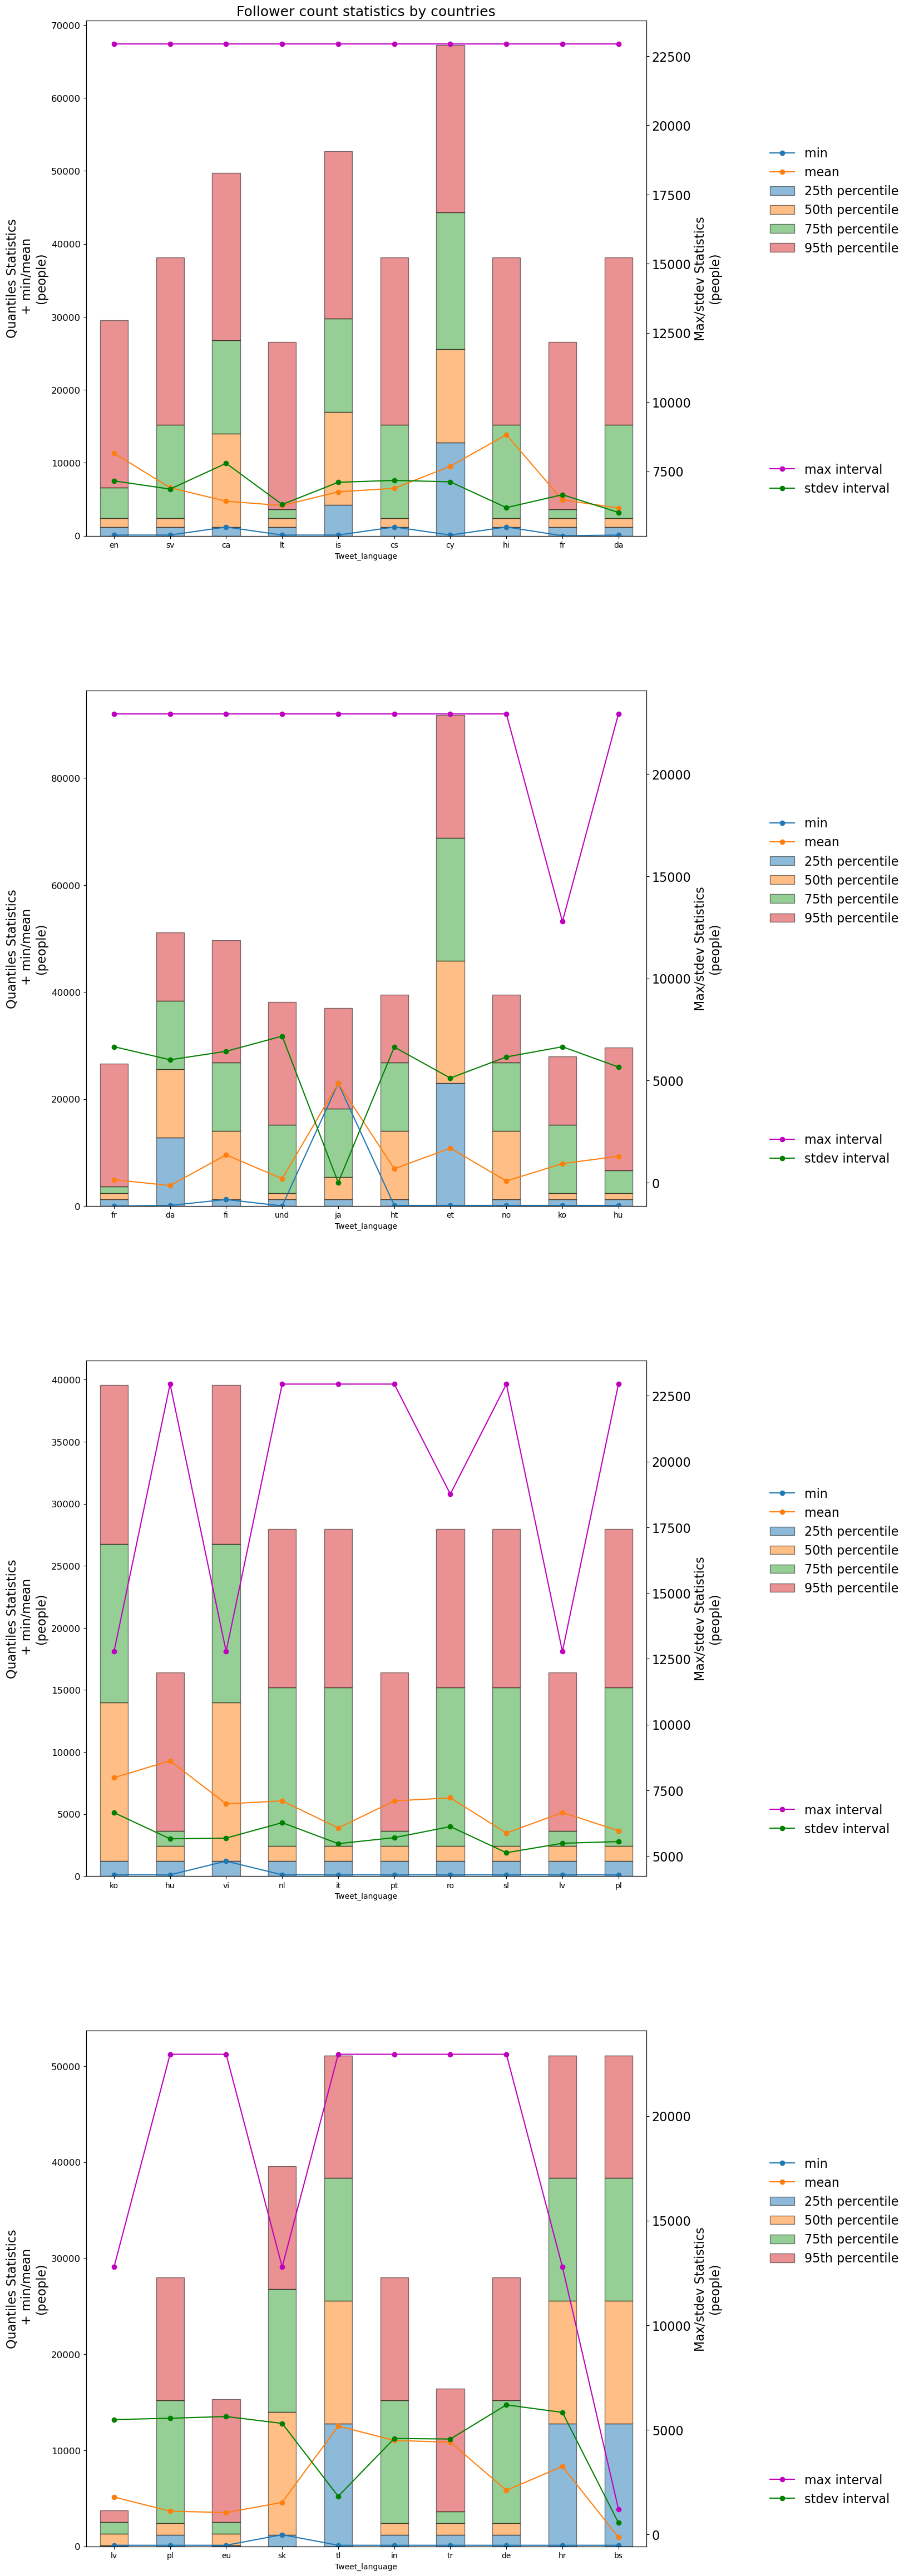

In [134]:
bar_columns = ['25th percentile', '50th percentile'
               , '75th percentile', '95th percentile']
line_columns1 = ['min', 'mean'] 
line_columns2 = ['max', 'stddev'] 
language_followers_statistic_df = language_followers_statistic_df.sort_values(
    by='95th percentile', ascending=False
)
figsize=(13, 59)
nrows = math.ceil(len(all_tweet_languages)/10)
fig, axs = plt.subplots(nrows=nrows, figsize=figsize)

d = axs[0].set_title('Follower count statistics by countries', fontsize=18)
for i in range (nrows):
    language_followers_statistic_sub_df = language_followers_statistic_df.iloc[i*8:i*8+10,]
    plot1 = language_followers_statistic_sub_df[['tweet_language'] + bar_columns] \
        .groupby(['tweet_language']).agg(np.mean).plot(
        kind='bar', stacked=True, grid=False, alpha=0.5, edgecolor='black', ax=axs[i], 
    )
    plot2 = language_followers_statistic_sub_df[['tweet_language'] + line_columns1].plot(x='tweet_language', ax=axs[i], marker='o')
    ax2 = axs[i].twinx()
    plot3 = language_followers_statistic_sub_df[['tweet_language'] + line_columns2].plot( x='tweet_language', ax=ax2, marker='o', color=['m', 'g'])
    a = axs[i].legend(loc='center left', fontsize=16, bbox_to_anchor=(1.2, 0.65), frameon=False)
    a = ax2.legend(  labels=['max interval', 'stdev interval']
                   , loc="center left", fontsize=16, bbox_to_anchor=(1.2, 0.11), frameon=False)
    b = axs[i].set_xticklabels(language_followers_statistic_sub_df['tweet_language'],rotation = 'horizontal', fontsize='small')
    c = axs[i].set_xlabel('Tweet_language', fontsize='small');
    d = axs[i].set_ylabel('Quantiles Statistics\n + min/mean\n(people)', fontsize=16);
    e = ax2.set_ylabel('Max/stdev Statistics\n(people)', fontsize=16)
    ax2.tick_params(axis='y', labelsize=16)
    b = plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=True)

plt.subplots_adjust(hspace=0.3)
plt.show();

Вывод процентной статистике по датам регистраций пользователей:

Top 5 dates registrations:


/tmp/ipykernel_106/37853426.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  xsticks_label = axs[0].set_xticklabels(highest_account_creation_date_df['account_creation_date'], rotation='vertical', fontsize='small')


account_creation_date  count  percentage
0            2011-04-29  35506   51.694718
1            2014-03-12  22466   32.709219
2            2015-03-22   3829    5.574806
3            2014-03-30   2223    3.236562
4            2009-05-03   2026    2.949741
0                others   2634    3.834954

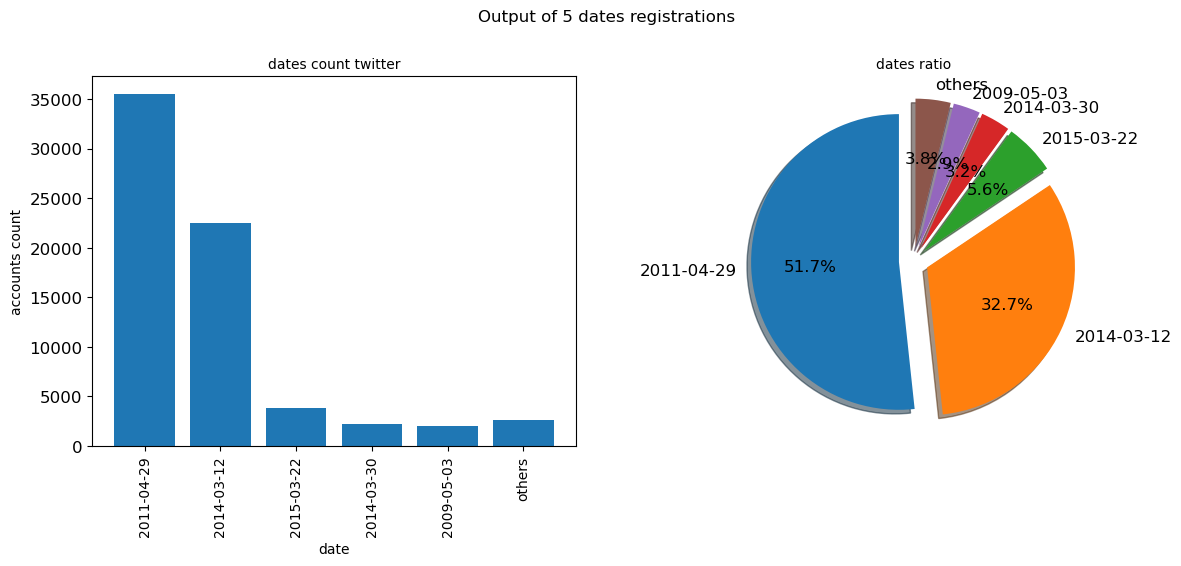

In [135]:
total_account_creation_date_count = df.count()
highest_account_creation_date_df = df.select(df.account_creation_date) \
    .groupBy(df.account_creation_date) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()


highest_account_creation_date_df['percentage'] = highest_account_creation_date_df['count'] \
    / total_account_creation_date_count * 100

others = {
    'account_creation_date': 'others', 
    'count': total_account_creation_date_count - np.sum(highest_account_creation_date_df['count']), 
    'percentage': 100 - np.sum(highest_account_creation_date_df['percentage'])
}

highest_account_creation_date_df = pd.concat([highest_account_creation_date_df,pd.DataFrame.from_dict([others])])


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.35))

plot0 = axs[0].bar(x=highest_account_creation_date_df['account_creation_date'], height=highest_account_creation_date_df['count'])
title0 = axs[0].set_title('dates count twitter', fontsize='small')
xlabel0 = axs[0].set_xlabel('date', fontsize='small')
ylabel0 = axs[0].set_ylabel('accounts count', fontsize='small')
xsticks_label = axs[0].set_xticklabels(highest_account_creation_date_df['account_creation_date'], rotation='vertical', fontsize='small')
explode = (0.1,) * len(highest_account_creation_date_df['account_creation_date'])
title1 = axs[1].set_title('dates ratio', fontsize='small')
plot1 = axs[1].pie(x=highest_account_creation_date_df['percentage'],
                   labels=highest_account_creation_date_df['account_creation_date'],
                   autopct='%1.1f%%',
                   shadow=True,
                   explode=explode,
                   startangle=90,
                   radius=1)

print('Top 5 dates registrations:')
highest_account_creation_date_df

text = fig.text(0.5, 1.02, 'Output of 5 dates registrations', ha='center', va='top', transform=fig.transFigure)

Отдельно "dates ratio"

<Axes: ylabel='percent'>

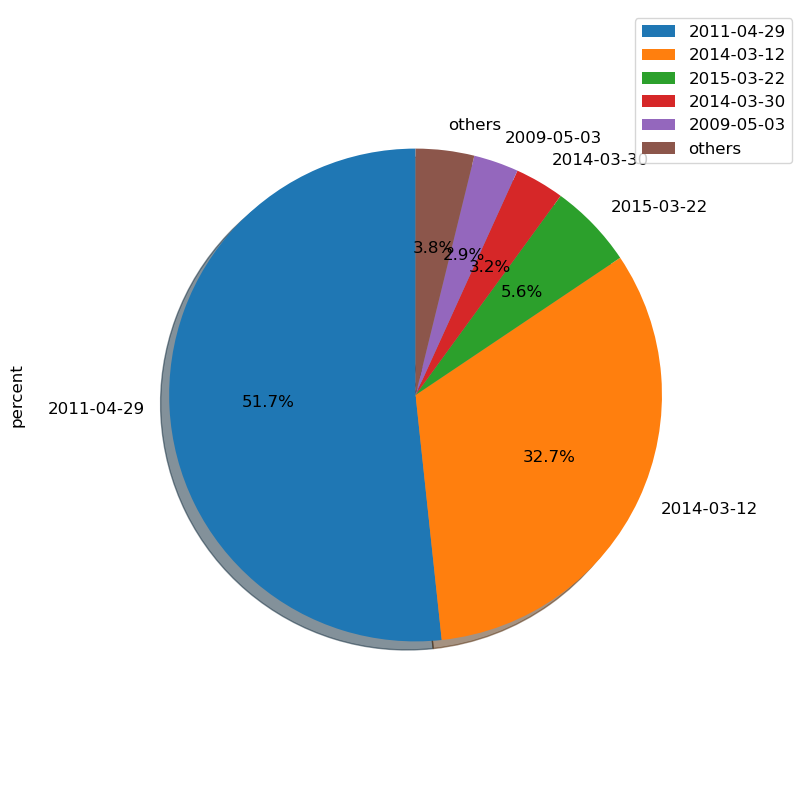

In [136]:
account_creation_date_df = df.select(df.account_creation_date) \
    .groupBy(df.account_creation_date) \
    .count() \
    .orderBy("count", ascending=False) \
    .limit(5) \
    .toPandas()

account_creation_date_df['percent'] = account_creation_date_df['count'] \
    / total_twitter_count * 100

others = {
    'account_creation_date': 'others', 
    'count': total_twitter_count - np.sum(account_creation_date_df['count']), 
    'percent': 100 - np.sum(account_creation_date_df['percent'])
}

account_creation_date_df = pd.concat([account_creation_date_df,pd.DataFrame.from_dict([others])])

account_creation_date_df.plot.pie(
    y='percent',
    labels=account_creation_date_df['account_creation_date'], 
    autopct='%1.1f%%', 
    shadow=True, 
    startangle=90, 
    radius=0.8,
    figsize=(10, 10)
)

Выводим список стран и количество регистраций в определенную дату, а именно "2011-04-29"

In [137]:
date_ct_df = df.select(df.tweet_language).filter(df.account_creation_date=='2011-04-29') \
    .groupBy(df.tweet_language) \
    .count() \
    .orderBy('count', ascending=False)

date_ct_df.toPandas()

tweet_language  count
0              es  27673
1              en   2277
2             und   2183
3              pt    956
4              it    323
5              tl    283
6              fr    238
7              id    169
8              in    157
9              pl    156
10             nl    115
11             ht    115
12             lv     98
13             et     91
14             vi     89
15             de     74
16             tr     61
17             lt     57
18             hu     48
19             fi     47
20             sl     40
21             da     40
22             sk     39
23             no     36
24             sv     34
25             eu     20
26             ro     19
27             cy     18
28             is     14
29             ca     10
30             cs      9
31             hr      7
32             bs      3
33             ru      2
34             hi      1
35             el      1
36             ar      1
37             bg      1
38             ko      1

Постройте диаграмму рассеяния между признаками "tweet_language" и "account_creation_date". Т.е между языком твитов и их датой регистрации
Чем темнее точка, тем больше совпадений

<Figure size 3000x1000 with 0 Axes>

Text(0.5, 1.0, 'Scatter plot between tweet language and Account creation date')

Text(0.5, 0, 'Tweet language')

Text(0, 0.5, 'Account creation date')

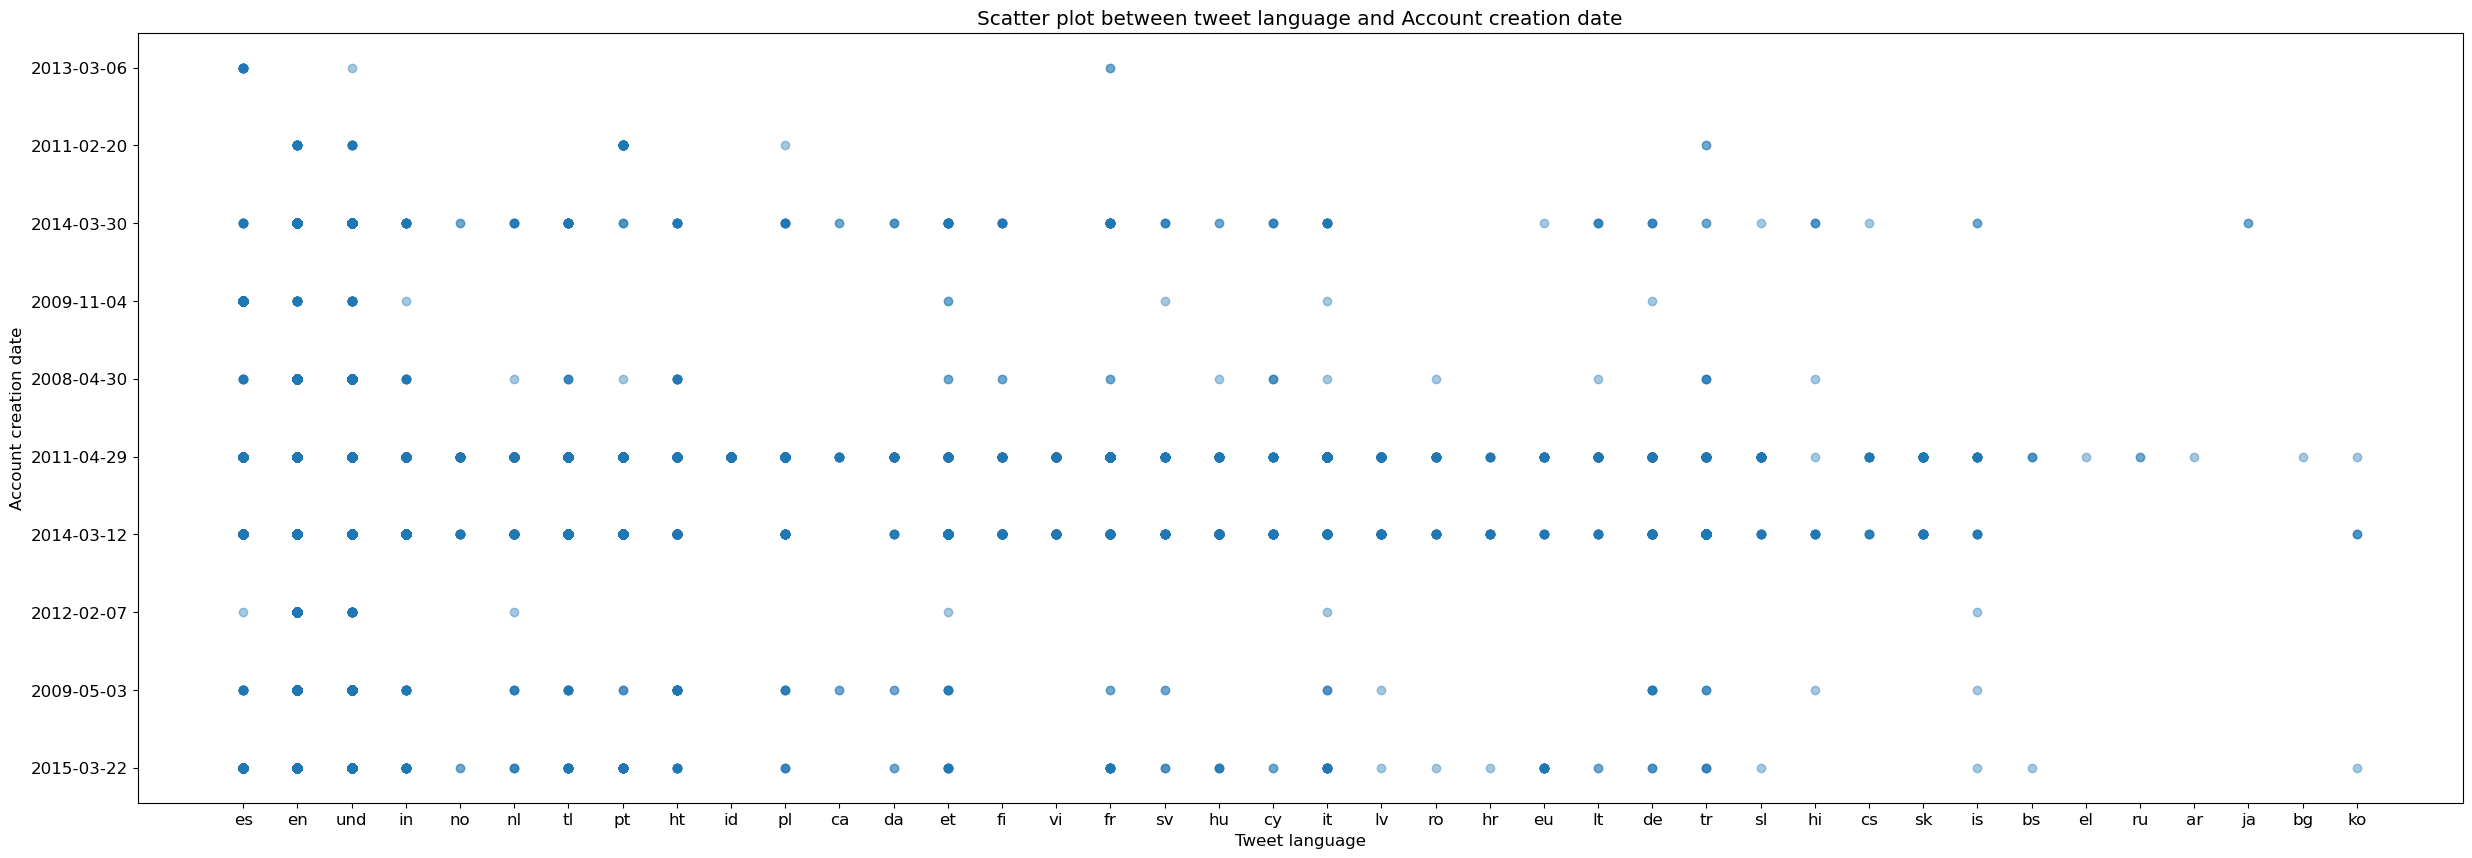

In [138]:
# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.tweet_language, df.account_creation_date).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(30, 10))
plt.scatter(df_pd['tweet_language'], df_pd['account_creation_date'], alpha=0.4)
plt.title('Scatter plot between tweet language and Account creation date')
plt.xlabel('Tweet language')
plt.ylabel('Account creation date')
plt.show()


Запрос для получения количества, среднего, минимального и максимального количества подписчиков для каждого языка

In [139]:
date_languages = df.select(df.tweet_language) \
    .distinct() \
    .rdd.flatMap(lambda x: x).collect()

# Query to get the count, average, minimum, and maximum follower count for each language
result_df = df.select(df.tweet_language, df.follower_count) \
    .filter(df.tweet_language.isin(date_languages)) \
    .groupBy(df.tweet_language).agg(
        F.count("tweet_language").alias("count"),
        F.avg("follower_count").alias("avg_follower_count"),
        F.min("follower_count").alias("min_follower_count"),
        F.max("follower_count").alias("max_follower_count")
    ) \
    .orderBy('count', ascending=False) \
    .toPandas()

result_df


tweet_language  count  avg_follower_count  min_follower_count  \
0              es  30732         1199.316087                14.0   
1              en  13831        11326.617743               108.0   
2              tl  12902        12521.150442               108.0   
3             und   4379         5103.175839                14.0   
4              pt   1757         6061.889015               108.0   
5              in   1209        11025.021505               108.0   
6              et    541        10814.138632               108.0   
7              it    433         3881.314088               108.0   
8              tr    387        10837.596899               108.0   
9              fr    353         4915.915014                14.0   
10             ht    257         6964.175097               108.0   
11             nl    203         6066.300493               108.0   
12             pl    200         3659.220000               108.0   
13             hu    170         9295.970588               108.0   
14             id    169         1210.000000              1210.0   
15             lv    151         5130.649007               108.0   
16             vi    148         5822.763514              1210.0   
17             fi    140         9562.907143              1210.0   
18             de    132         5831.568182               108.0   
19             lt     74         4156.121622               108.0   
20             sv     68         6601.632353               108.0   
21             sk     55         4576.109091              1210.0   
22             cy     54         9540.185185               108.0   
23             da     53         3821.962264               108.0   
24             no     52         4673.923077               108.0   
25             sl     50         3474.080000               108.0   
26             eu     43         3509.488372               108.0   
27             ro     35         6308.485714               108.0   
28             is     25         6030.680000               108.0   
29             hr     21         8320.523810               108.0   
30             cs     15         6516.200000              1210.0   
31             hi     15        13870.466667              1210.0   
32             ca     14         4743.857143              1210.0   
33             ko      5         7932.200000               108.0   
34             bs      4          934.500000               108.0   
35             ru      2         1210.000000              1210.0   
36             ja      2        22948.000000             22948.0   
37             el      1         1210.000000              1210.0   
38             ar      1         1210.000000              1210.0   
39             bg      1         1210.000000              1210.0   

    max_follower_count  
0              22948.0  
1              22948.0  
2              22948.0  
3              22948.0  
4              22948.0  
5              22948.0  
6              22948.0  
7              22948.0  
8              22948.0  
9              22948.0  
10             22948.0  
11             22948.0  
12             22948.0  
13             22948.0  
14              1210.0  
15             12781.0  
16             12781.0  
17             22948.0  
18             22948.0  
19             22948.0  
20             22948.0  
21             12781.0  
22             22948.0  
23             22948.0  
24             22948.0  
25             22948.0  
26             22948.0  
27             18765.0  
28             22948.0  
29             12781.0  
30             22948.0  
31             22948.0  
32             22948.0  
33             12781.0  
34              1210.0  
35              1210.0  
36             22948.0  
37              1210.0  
38              1210.0  
39              1210.0

Запрос для получения среднего количества подписчиков по датам регистрации

<Axes: xlabel='account_creation_date'>

Text(0.5, 1.0, 'Average Follower Count by Account Creation Date')

Text(0.5, 0, 'Account Creation Date')

Text(0, 0.5, 'Average Follower Count')

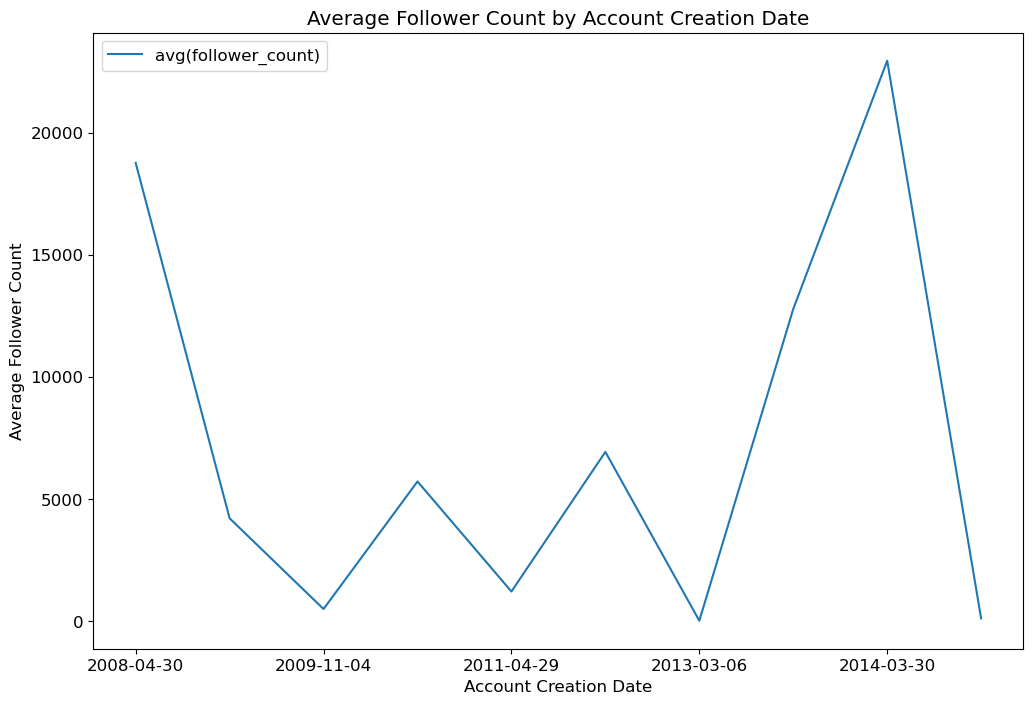

In [140]:
# Запрос для получения среднего количества подписчиков по датам регистрации
avg_follower_count_df = df.groupBy('account_creation_date').avg('follower_count').toPandas()

# Сортировка данных по дате в обратном порядке и построение графика
avg_follower_count_df.sort_values(by='account_creation_date', ascending=True).plot(x='account_creation_date', y='avg(follower_count)', kind='line', figsize=(12, 8))
plt.title('Average Follower Count by Account Creation Date')
plt.xlabel('Account Creation Date')
plt.ylabel('Average Follower Count')
plt.show()
